In [168]:
import numpy as np
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as units

from BASE9Analysis import readGaiaData
from BASE9Analysis import findSeparation
from scipy.stats import ks_2samp

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# from matplotlib import font_manager
# #point to font directory and find files within it
# font_dirs = ['/Library/Fonts/']
# font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
# #add fonts
# for font_file in font_files:
#     font_manager.fontManager.addfont(font_file)
# # set font
# plt.rcParams['font.family'] = 'Font Here'

%matplotlib inline

In [169]:
# %load_ext autoreload
# %autoreload 2
# from getGaiaData import GaiaClusterMembers

In [170]:
# cluster = GaiaClusterMembers(295.3250, 40.19, 1)
# cluster.verbose = 1
# cluster.getData()

In [171]:
# cluster.saveDataToFile('clusterGaiaData.ecsv')

In [172]:
#read data from ecsv and round to 4 decimals
originalGaia=readGaiaData('M67data.ecsv')
originalGaia=originalGaia.round(4)

In [173]:
#define filepaths for samplemasses, memberships, and photometry
sm = "/Users/Claire/Documents/Code/current/ANNACRNN/plotting/run21_int_19co_ov/result/cluster.massSamples"
mem = "/Users/Claire/Documents/Code/current/ANNACRNN/plotting/run21_int_19co_ov/result/cluster.membership"
ph = "/Users/Claire/Documents/Code/current/ANNACRNN/plotting/run21_int_19co_ov/NGC6819.phot"

In [174]:
#create dataframe for photometry, and define analysis columns
phot = pd.read_csv(ph, sep='\s+')
phot['m1Mean'] = -1
phot['m1Std'] = -1
phot['m2Mean'] = -1
phot['m2Std'] = -1
phot['qMean'] = -1
phot['qStd'] = -1
phot['memMean'] = -1
phot['memStd'] = -1
phot['member'] = False
phot['binary'] = False
phot

,id,G,G_BP,G_RP,g_ps,r_ps,i_ps,z_ps,y_ps,J_2M,...,m1Mean,m1Std,m2Mean,m2Std,qMean,qStd,memMean,memStd,member,binary
0,10010400015,9.9643,11.6368,8.7188,12.0640,11.9650,10.1610,9.0880,8.5260,6.758,...,-1,-1,-1,-1,-1,-1,-1,-1,False,False
1,10618000016,10.0908,11.4559,8.9425,13.2814,10.9032,9.0598,8.5864,8.8477,7.240,...,-1,-1,-1,-1,-1,-1,-1,-1,False,False
2,10719500017,10.1428,11.4292,9.0287,99.9000,99.9000,99.9000,99.9000,99.9000,7.356,...,-1,-1,-1,-1,-1,-1,-1,-1,False,False
3,11321600029,10.9064,11.7692,10.0000,99.9000,99.9000,99.9000,99.9000,99.9000,8.723,...,-1,-1,-1,-1,-1,-1,-1,-1,False,False
4,10007800034,11.0790,11.9665,10.1455,99.9000,99.9000,99.9000,99.9000,99.9000,8.819,...,-1,-1,-1,-1,-1,-1,-1,-1,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1905,10639026771,20.4824,99.9000,99.9000,99.9000,99.9000,99.9000,99.9000,99.9000,99.900,...,-1,-1,-1,-1,-1,-1,-1,-1,False,False
1906,10095627116,20.5168,99.9000,99.9000,21.0998,99.9000,20.2313,99.9000,99.9000,99.900,...,-1,-1,-1,-1,-1,-1,-1,-1,False,False
1907,10130227255,20.5313,99.9000,99.9000,99.9000,20.5410,20.3388,99.9000,99.9000,99.900,...,-1,-1,-1,-1,-1,-1,-1,-1,False,False
1908,10572927462,20.5560,99.9000,99.9000,99.9000,99.9000,99.9000,99.9000,99.9000,16.851,...,-1,-1,-1,-1,-1,-1,-1,-1,False,False


In [175]:
# get the IDs for the samplemasses
massIDs = np.loadtxt(sm,max_rows = 1, dtype=str)
massIDs = np.char.replace(massIDs,'mass','')
massIDs = np.char.replace(massIDs,'ratio','')
massIDs = np.char.replace(massIDs,'"','')
massIDs = (massIDs[massIDs != '']) 
massIDs

array(['10010400015', '10010400015', '10618000016', ..., '10130227255',
       '10572927462', '10572927462'], dtype='<U11')

In [176]:
# get the masses
masses = np.loadtxt(sm,skiprows=1)
print(masses.shape)
print(masses.shape[1]/2.)
print(type(masses))

(9341, 3818)
1909.0
<class 'numpy.ndarray'>


In [177]:
# get the memberships 
membership = np.loadtxt(mem)
print(membership.shape)

(9341, 1909)


In [178]:
#calculate the binary fraction
nBinary = 0
nCluster = 0
count = 0
# m1ArrTot = []
for i in range(0,masses.shape[1],2):
    # get the row in the phot file
    iden = int(massIDs[i])
    row = phot.loc[(phot['id'] == iden)]
    #print(row['id'])
    
    # get the column in the membership file
    
    imem = int((i/2))
    memArr = membership[:,imem]
    memMean = np.mean(memArr)
    memStd = np.std(memArr)
    
     #add to the phot df
    phot.at[row.index[0], 'memMean'] = memMean
    phot.at[row.index[0], 'memStd'] = memStd
    
    if (memMean - 3*memStd > 0):
        phot.at[row.index[0], 'member'] = True

        nCluster += 1
        
        # get the masses
        m1Arr = masses[:,i]
        # m1ArrTot.append(m1Arr)
        qArr = masses[:,(i + 1)]
        m2Arr = m1Arr*qArr
        m2Mean = np.mean(m2Arr)
        m1Mean = np.mean(m1Arr)
        m2Std = np.std(m2Arr)
        qMean = np.mean(qArr)
        qStd = np.std(qArr)

        # add to the phot df masses (to do)
        phot.at[row.index[0], 'qMean'] = qMean
        phot.at[row.index[0], 'qStd'] = qStd
        phot.at[row.index[0], 'm1Mean'] = m1Mean
        phot.at[row.index[0], 'm2Mean'] = m2Mean
        
    
        if (m2Mean - 3*m2Std > 0): #if there is a greater than 3sig difference from mean, include as binary
            nBinary += 1
            phot.at[row.index[0], 'binary'] = True
            
        if (qMean>=0.5): #exclude mass ratios < .5 
            count += 1
            
    #print(m1Arr)   
print("# Binaries:", nBinary, "\n# Cluster objects:", nCluster, \
 "\nBinary Fraction:", nBinary/nCluster, "\nStd:", np.sqrt(nBinary)/nCluster, \
  "\nq>=0.5 Binaries:", count, "\nq>=0.5 binary fraction:", count/nCluster, \
    "\nq>=0.5 std:", np.sqrt(count)/nCluster)

# Binaries: 471 
# Cluster objects: 1726 
Binary Fraction: 0.2728852838933951 
Std: 0.01257389015887063 
q>=0.5 Binaries: 409 
q>=0.5 binary fraction: 0.2369640787949015 
q>=0.5 std: 0.011717119592211288


In [179]:
# plt.hist(m1ArrTot)
# plt.xlim(0,10)

In [180]:
#include only cluster members and nonbinary stars
singlePhot = phot.loc[(phot['member']) & (phot['binary']== False)]
singlePhot['binary'].unique() #check all binary columns are false
# singlePhot

array([False])

In [181]:
#include only binary stars
binaryPhot = phot.loc[phot['binary']]
binaryPhot['binary'].unique() #check all binary columns are true
#photBinary

array([ True])

In [182]:
#select photometry between magnitudes for single and binary stars
topmag=15
bottommag=18.5
cutSinglePhot = singlePhot.loc[(singlePhot['G']  > topmag) & (singlePhot['G']  < bottommag)]
cutBinaryPhot = binaryPhot.loc[(binaryPhot['G']  > topmag) & (binaryPhot['G']  < bottommag)]
# cutSinglePhot
# cutBinaryPhot

In [183]:
binaryGaiaData = pd.merge(originalGaia, binaryPhot, on=['G','G_BP'])
singleGaiaData = pd.merge(originalGaia, singlePhot, on=['G','G_BP'])
cutBinaryGaiaData = pd.merge(originalGaia, cutBinaryPhot, on=['G','G_BP'])
cutSingleGaiaData = pd.merge(originalGaia, cutSinglePhot, on=['G','G_BP'])

cutBinaryGaiaData

,source_id,G,G_BP,G_RP_x,ra,dec,id,G_RP_y,g_ps,r_ps,...,m1Mean,m1Std,m2Mean,m2Std,qMean,qStd,memMean,memStd,member,binary
0,2076280889898899072,18.0811,18.6603,17.3358,295.4883,39.9135,12633508638,17.3358,18.7807,18.0812,...,0.844400,-1,0.403495,-1,0.477958,0.066631,1.0,0.000000e+00,True,True
1,2076281581399164544,16.0097,16.3656,15.4828,295.4431,39.9309,12200302407,15.4828,16.4261,15.9994,...,1.194867,-1,0.482280,-1,0.403882,0.125642,1.0,0.000000e+00,True,True
2,2076282023770302848,15.0792,15.4044,14.5541,295.4843,39.9468,12166801134,14.5541,15.4713,15.0818,...,1.328925,-1,1.046687,-1,0.793005,0.146007,1.0,0.000000e+00,True,True
3,2076289685992697088,17.3912,17.8827,16.7503,295.1325,39.9203,12719305862,16.7503,17.9886,17.3668,...,0.948358,-1,0.432607,-1,0.456326,0.089892,1.0,0.000000e+00,True,True
4,2076291270845523712,17.8234,18.3815,17.1438,295.1386,40.0089,11641107485,17.1438,18.4977,17.8039,...,0.880352,-1,0.436445,-1,0.495878,0.062875,1.0,0.000000e+00,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,2076488319633876096,18.3683,19.0579,17.6162,295.2096,40.2132,10379610148,17.6162,19.2389,18.3724,...,0.794777,-1,0.526965,-1,0.663106,0.025763,1.0,0.000000e+00,True,True
354,2076488427020000256,17.2089,17.7541,16.5467,295.1979,40.2451,10517105256,16.5467,17.8837,17.1791,...,0.924321,-1,0.767874,-1,0.832050,0.060442,1.0,1.307153e-06,True,True
355,2076488461372222720,17.9176,18.4803,17.2369,295.1520,40.2126,10690107866,17.2369,18.5880,17.8995,...,0.868141,-1,0.390398,-1,0.449819,0.078201,1.0,0.000000e+00,True,True
356,2076488869389762688,18.4580,19.0945,17.7008,295.2493,40.2655,10401510652,17.7008,19.2875,18.4473,...,0.793533,-1,0.357789,-1,0.450991,0.068797,1.0,0.000000e+00,True,True


In [184]:
cutSingleGaiaData['distance'] = findSeparation(cutSingleGaiaData)
cutBinaryGaiaData['distance'] = findSeparation(cutBinaryGaiaData)
singleGaiaData['distance'] = findSeparation(singleGaiaData)
binaryGaiaData['distance'] = findSeparation(binaryGaiaData)

In [185]:
# Select rows where qMean is greater than or equal to 0.5
qcutSingle = singleGaiaData[singleGaiaData['qMean'] >= 0.5]
qcutBinary = binaryGaiaData[binaryGaiaData['qMean'] >= 0.5]

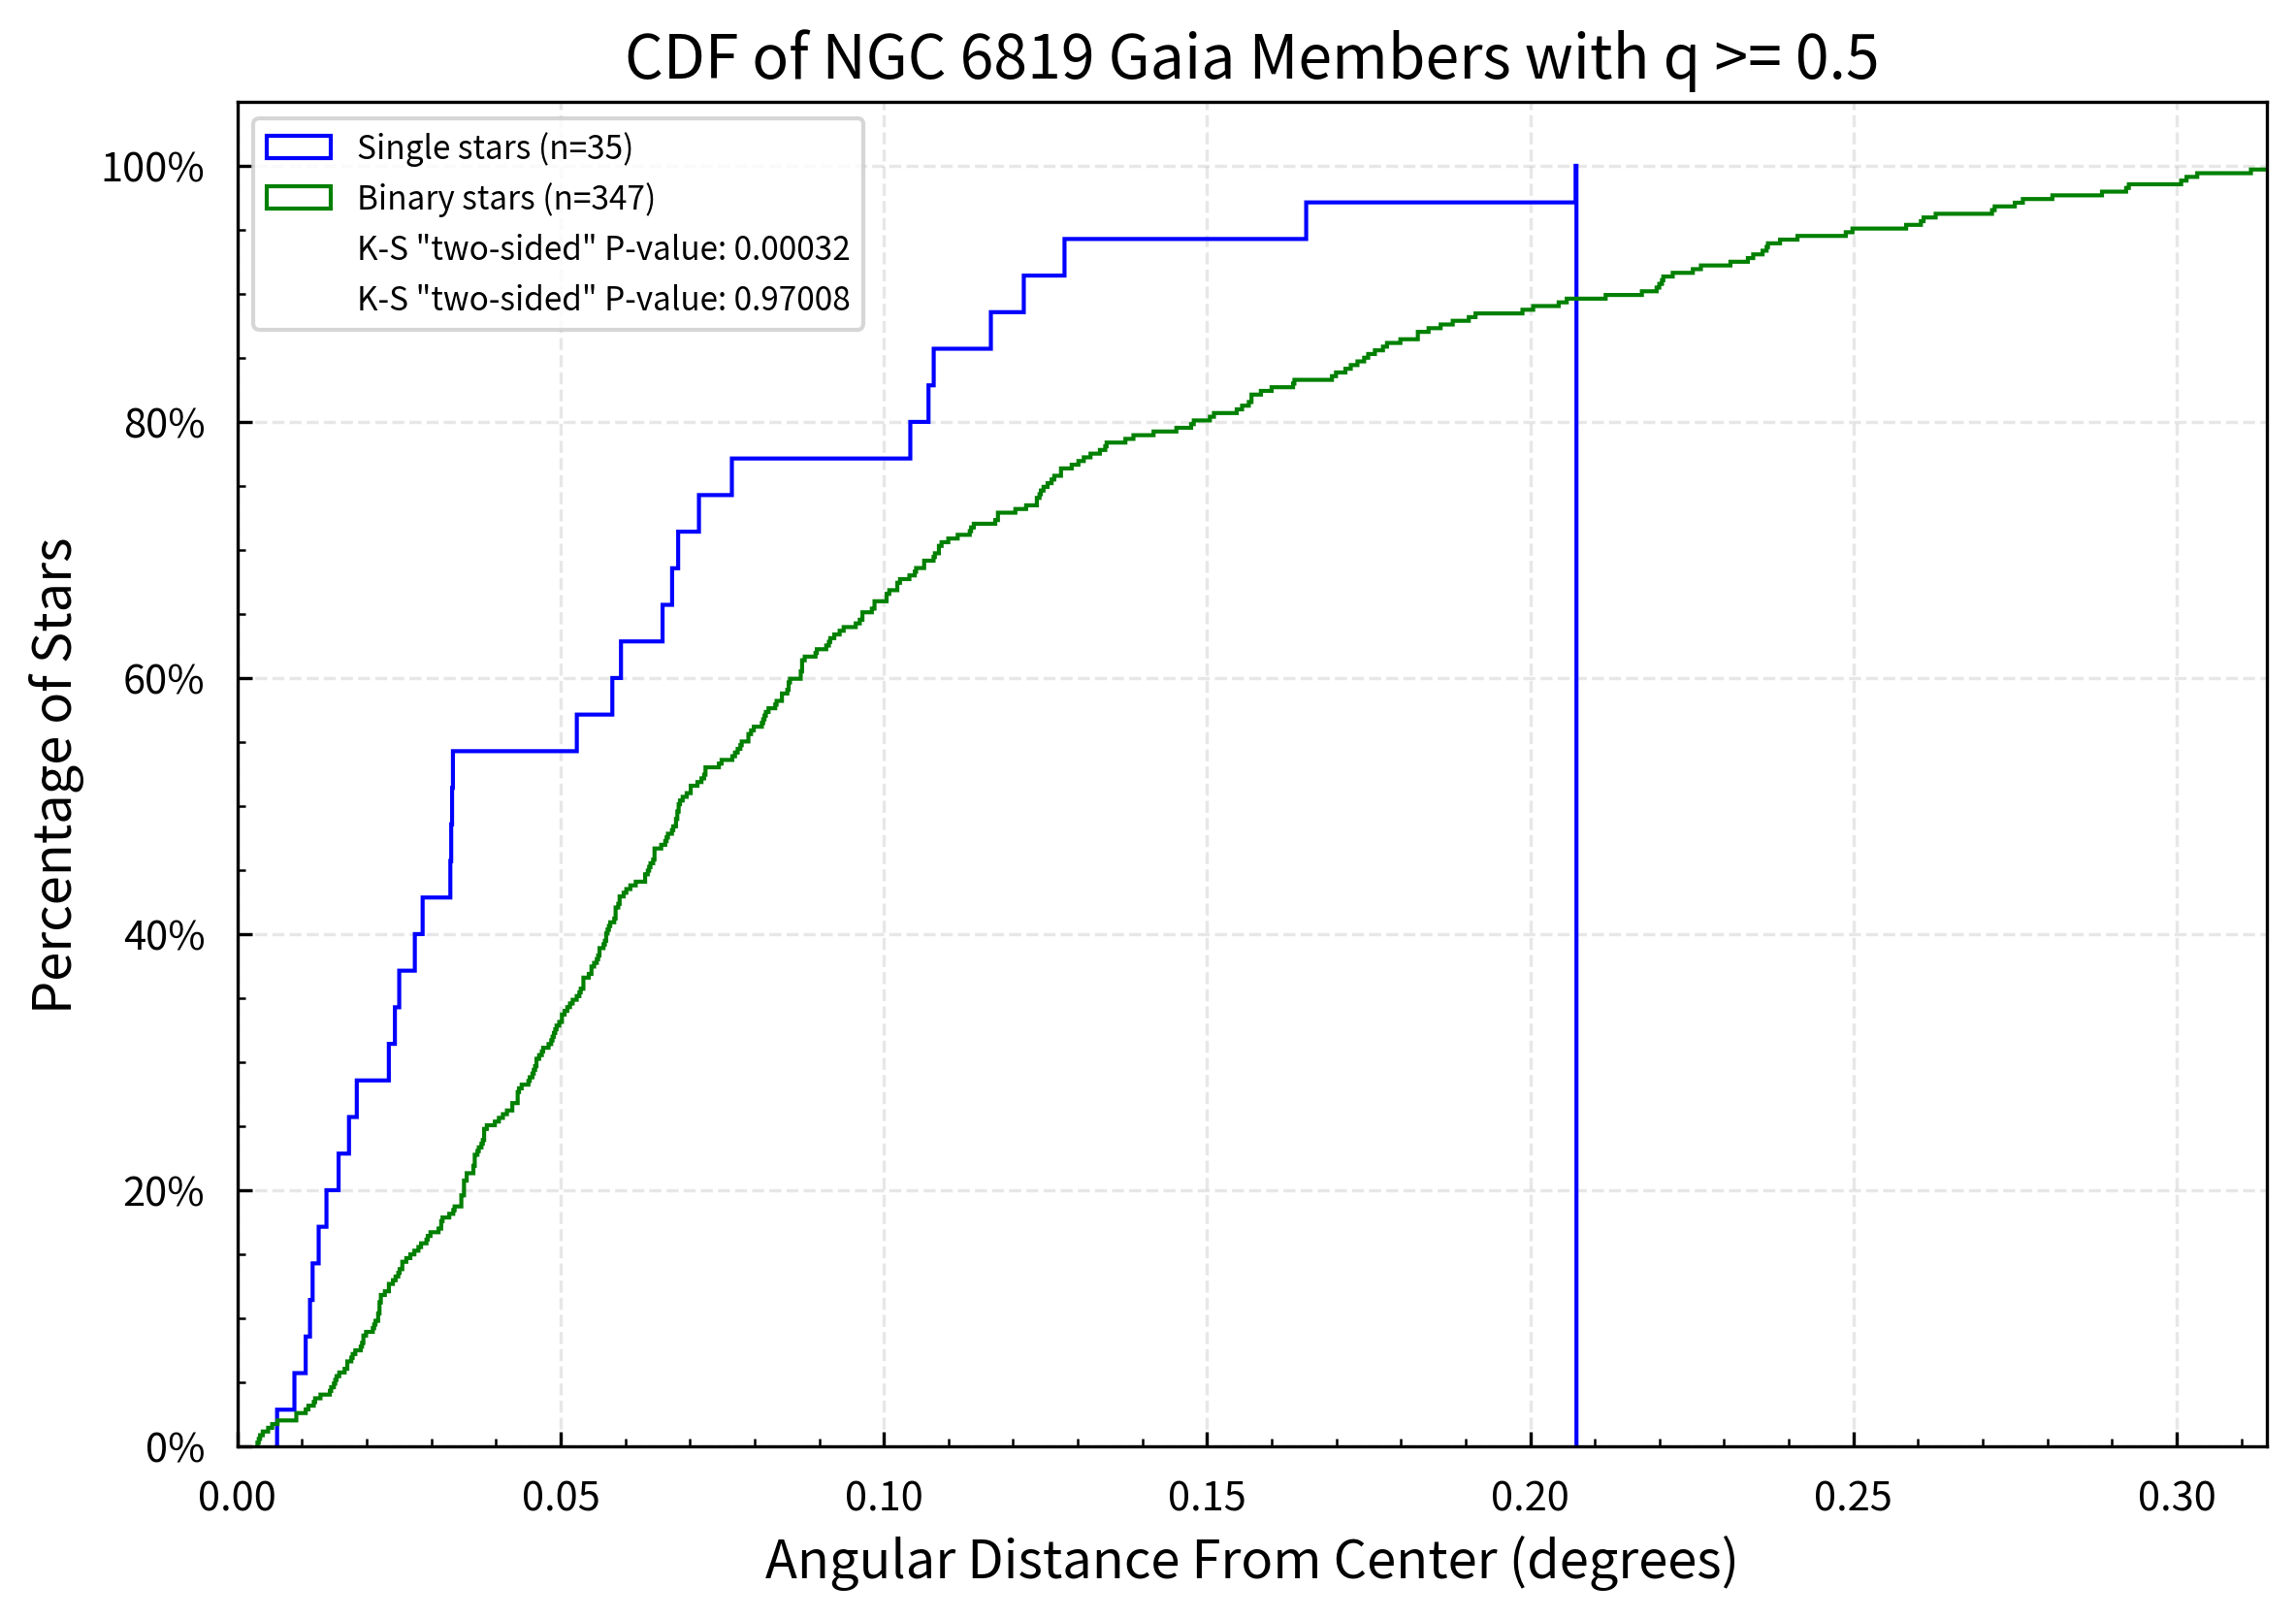

In [186]:
#massratio CDF
f,ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)

single = qcutSingle['distance']
binary = qcutBinary['distance']

singleSample = single.shape[0]
binarySample = binary.shape[0]

singlehist = ax.hist(single, cumulative = True, density = True, histtype = "step", bins = 1500, color='b', label=f'Single stars (n={singleSample}) ')
binaryhist = ax.hist(binary, cumulative = True, density = True, histtype = "step", bins = 1500,color='g', label= f'Binary stars (n={binarySample}) ')

ks_result, twoside_pvalue = ks_2samp(single,binary)
ks_result, less_pvalue = ks_2samp(single,binary,alternative='less')

plt.xlabel("Angular Distance From Center (degrees)", fontsize=13)
plt.ylabel("Percentage of Stars", fontsize=13)
plt.title("CDF of NGC 6819 Gaia Members with q >= 0.5", fontsize=15)
plt.grid(linestyle='--', alpha=0.3)

#plt.text(.008, .88, 'K-S "two-sided" P-value: 0.00032\nK-S "less" P-value: 0.970\nBinary sample: 347\nSingle sample: 35',fontsize = 10, 
#          bbox = dict(facecolor='w', boxstyle='round', edgecolor='lightgray'))
# custom_lines = [Line2D([0], [0], color='g',alpha=1, lw=2, ls='-'),
#                                 Line2D([0], [0], color='b',alpha=1, lw=2, ls='-'),
#                                 Line2D([0], [0], color='b',alpha=1, lw=2, ls='-')]

twoside= ax.plot(1, 1, alpha= 0, label=f'K-S "two-sided" P-value: {twoside_pvalue:.5f}', color=None, linestyle=None)
less= ax.plot(1, 1, alpha= 0, label=f'K-S "two-sided" P-value: {less_pvalue:.5f}', color=None, linestyle=None)
ax.legend(loc=2, fontsize=8)
#leg = ax.legend(handlelength=0, handletextpad=0, fancybox=True, loc=2, fontsize=9)
#plt.legend(custom_lines, ['Binary stars', 'Single stars'],loc=2, fontsize=10)

#plt.annotate(text="Binary stars", color='g', xy=(.104,.81), xytext=(.104,.81), size=12)
#plt.annotate(text="Single stars", color='b', xy=(.155,.69), xytext=(.155,.69), size=12)
from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
ax.yaxis.get_ticklocs(minor=True)
ax.minorticks_on()
ax.tick_params(which='both', direction="in")
ax.tick_params(axis='both', pad=8)
ax.set_xlim(0,.314)
plt.show()

KstestResult(statistic=0.09556462317844427, pvalue=0.002227899676058986)


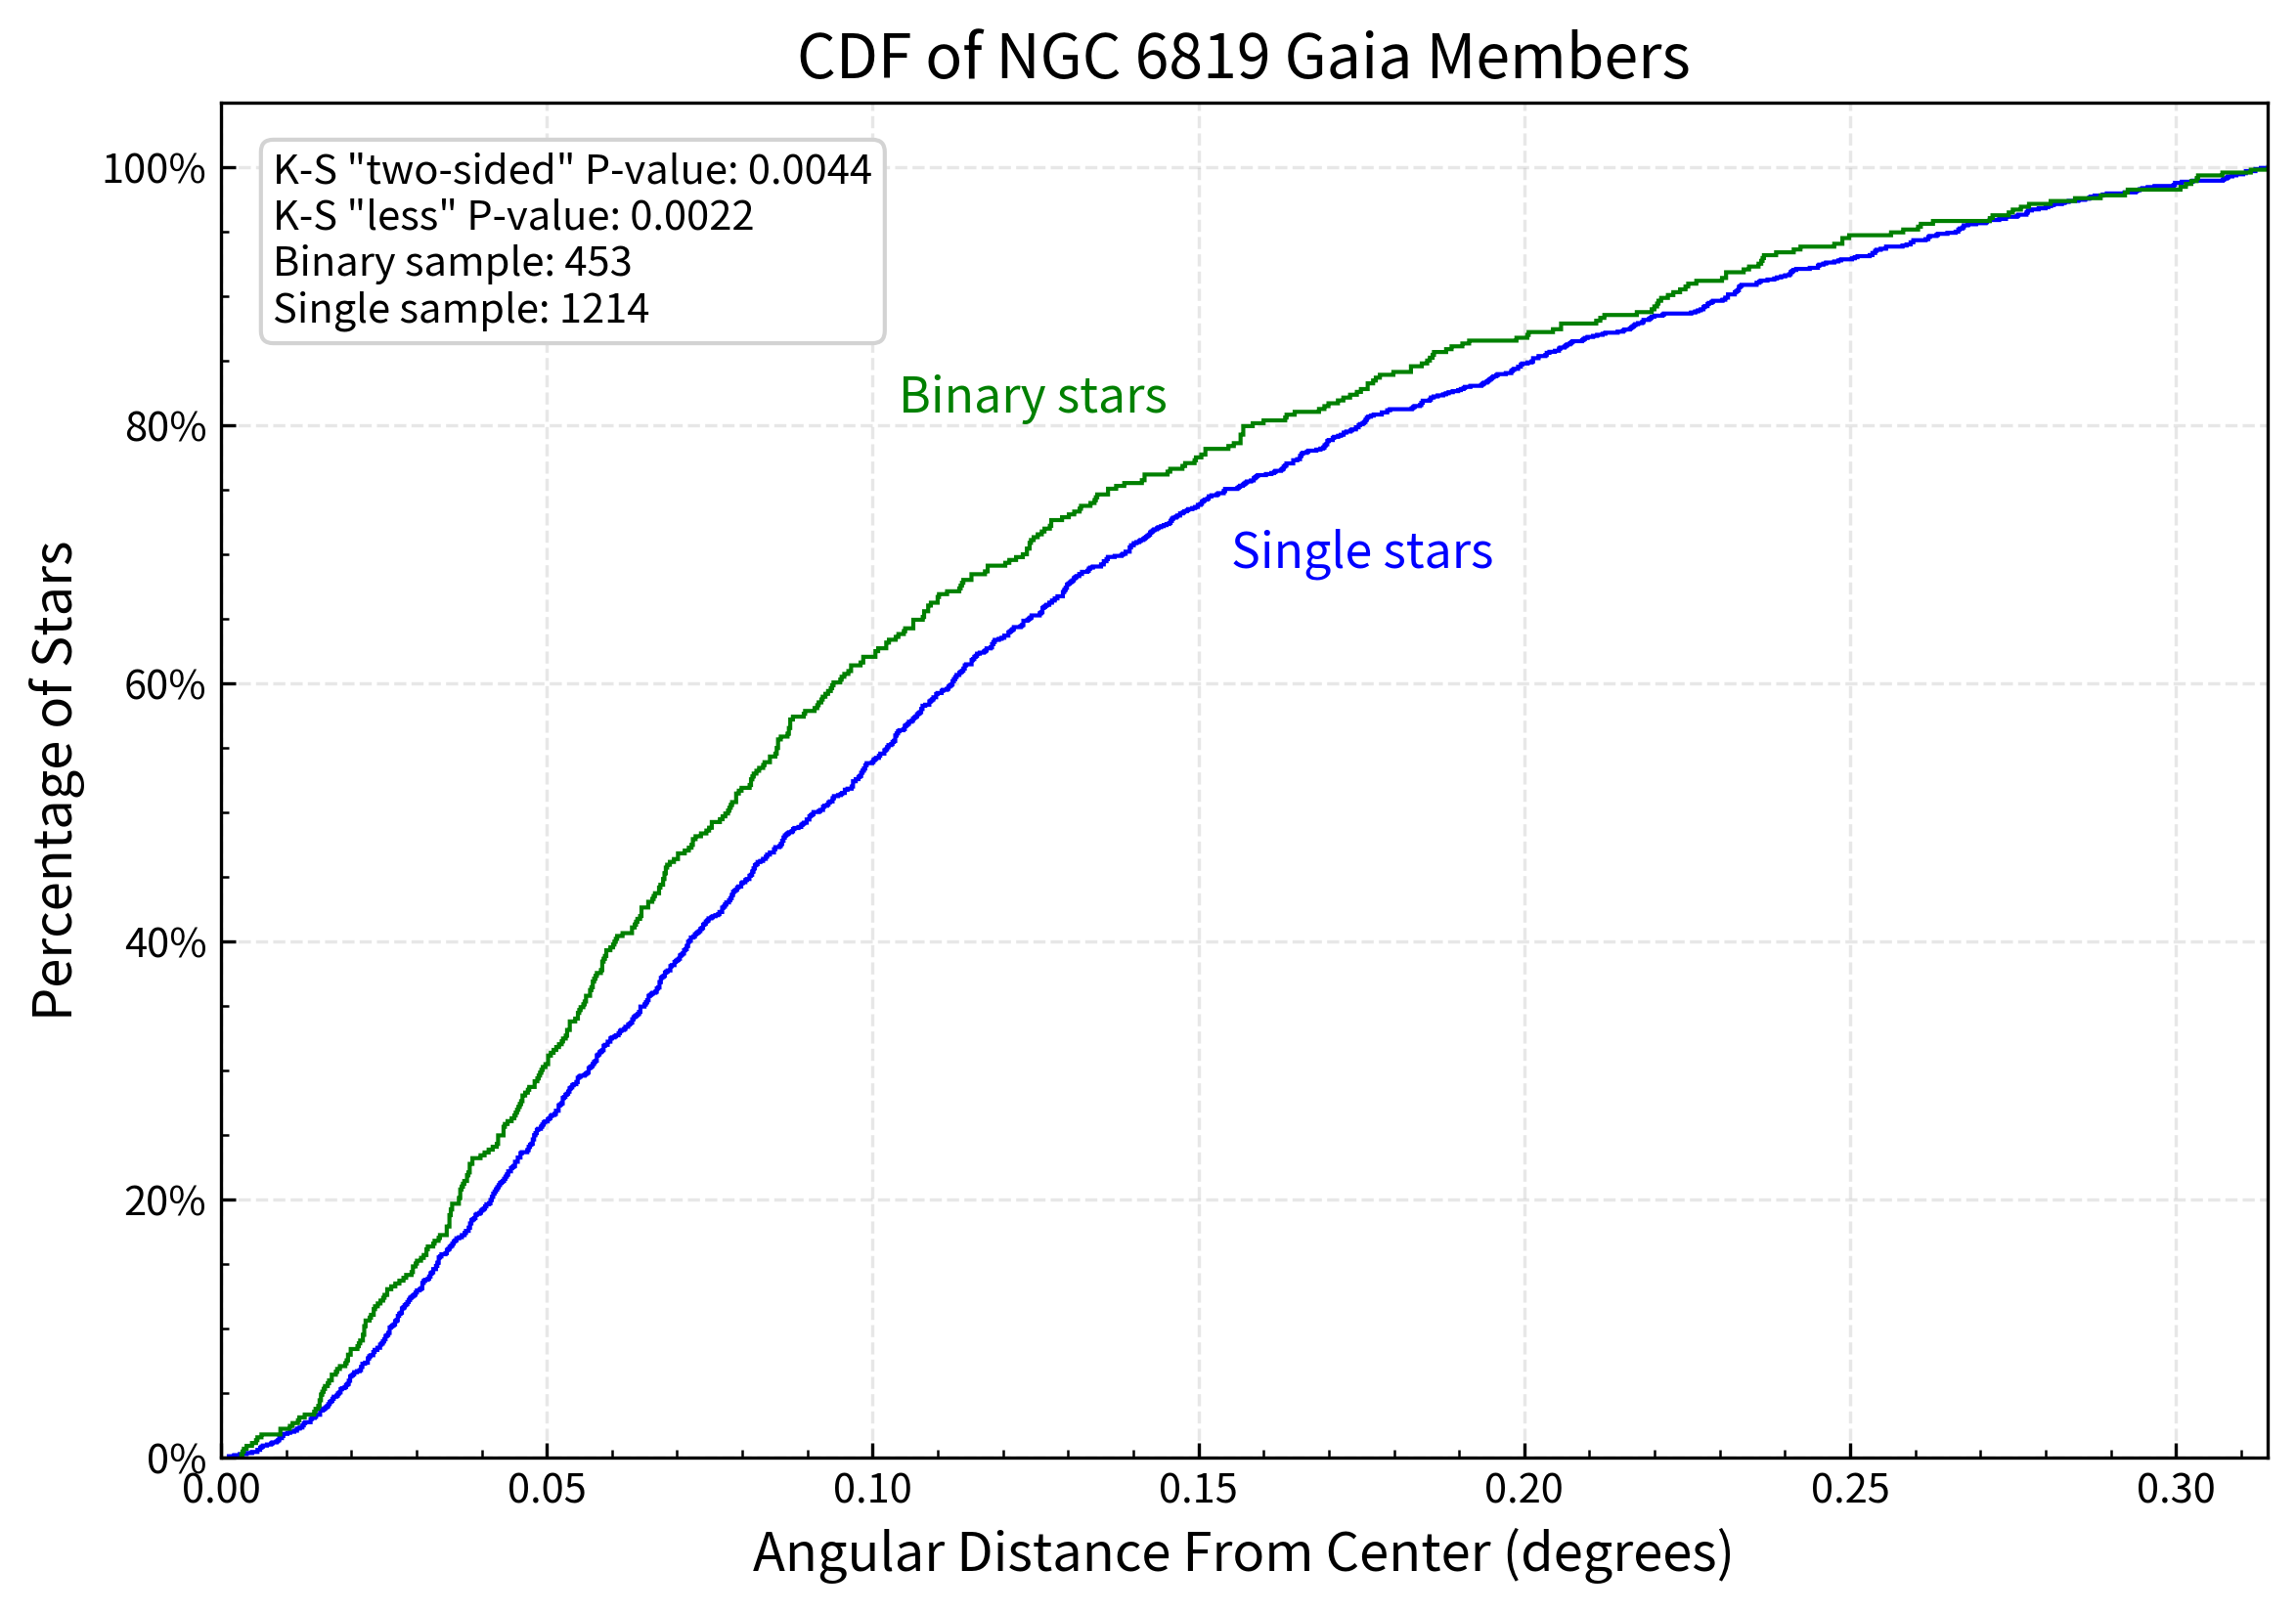

In [187]:
#full sample CDF
f,ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)

single = singleGaiaData['distance']
binary = binaryGaiaData['distance']

ax.hist(single, cumulative = True, density = True, histtype = "step", bins = 1500, color='b')
ax.hist(binary, cumulative = True, density = True, histtype = "step", bins = 1500,color='g')

ks_result = ks_2samp(single,binary, alternative='less')
print(ks_result)

plt.xlabel("Angular Distance From Center (degrees)", fontsize=13)
plt.ylabel("Percentage of Stars", fontsize=13)
plt.title("CDF of NGC 6819 Gaia Members", fontsize=15)
plt.text(.008, .88, 'K-S "two-sided" P-value: 0.0044\nK-S "less" P-value: 0.0022\nBinary sample: 453\nSingle sample: 1214',fontsize = 10, 
         bbox = dict(facecolor='w', boxstyle='round', edgecolor='lightgray'))
custom_lines = [ Line2D([0], [0], color='g',alpha=1, lw=2, ls='-'),
                                Line2D([0], [0], color='b',alpha=1, lw=2, ls='-'), ]
plt.grid(linestyle='--', alpha=0.3)
#plt.legend(custom_lines, ['Binary stars', 'Single stars'],loc=2, fontsize=10)
plt.annotate(text="Binary stars", color='g', xy=(.104,.81), xytext=(.104,.81), size=12)
plt.annotate(text="Single stars", color='b', xy=(.155,.69), xytext=(.155,.69), size=12)
from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
ax.yaxis.get_ticklocs(minor=True)
ax.minorticks_on()
ax.tick_params(which='both', direction="in")
ax.set_xlim(0,.314)
plt.show()

KstestResult(statistic=0.09817999301675978, pvalue=0.011053914911877691)


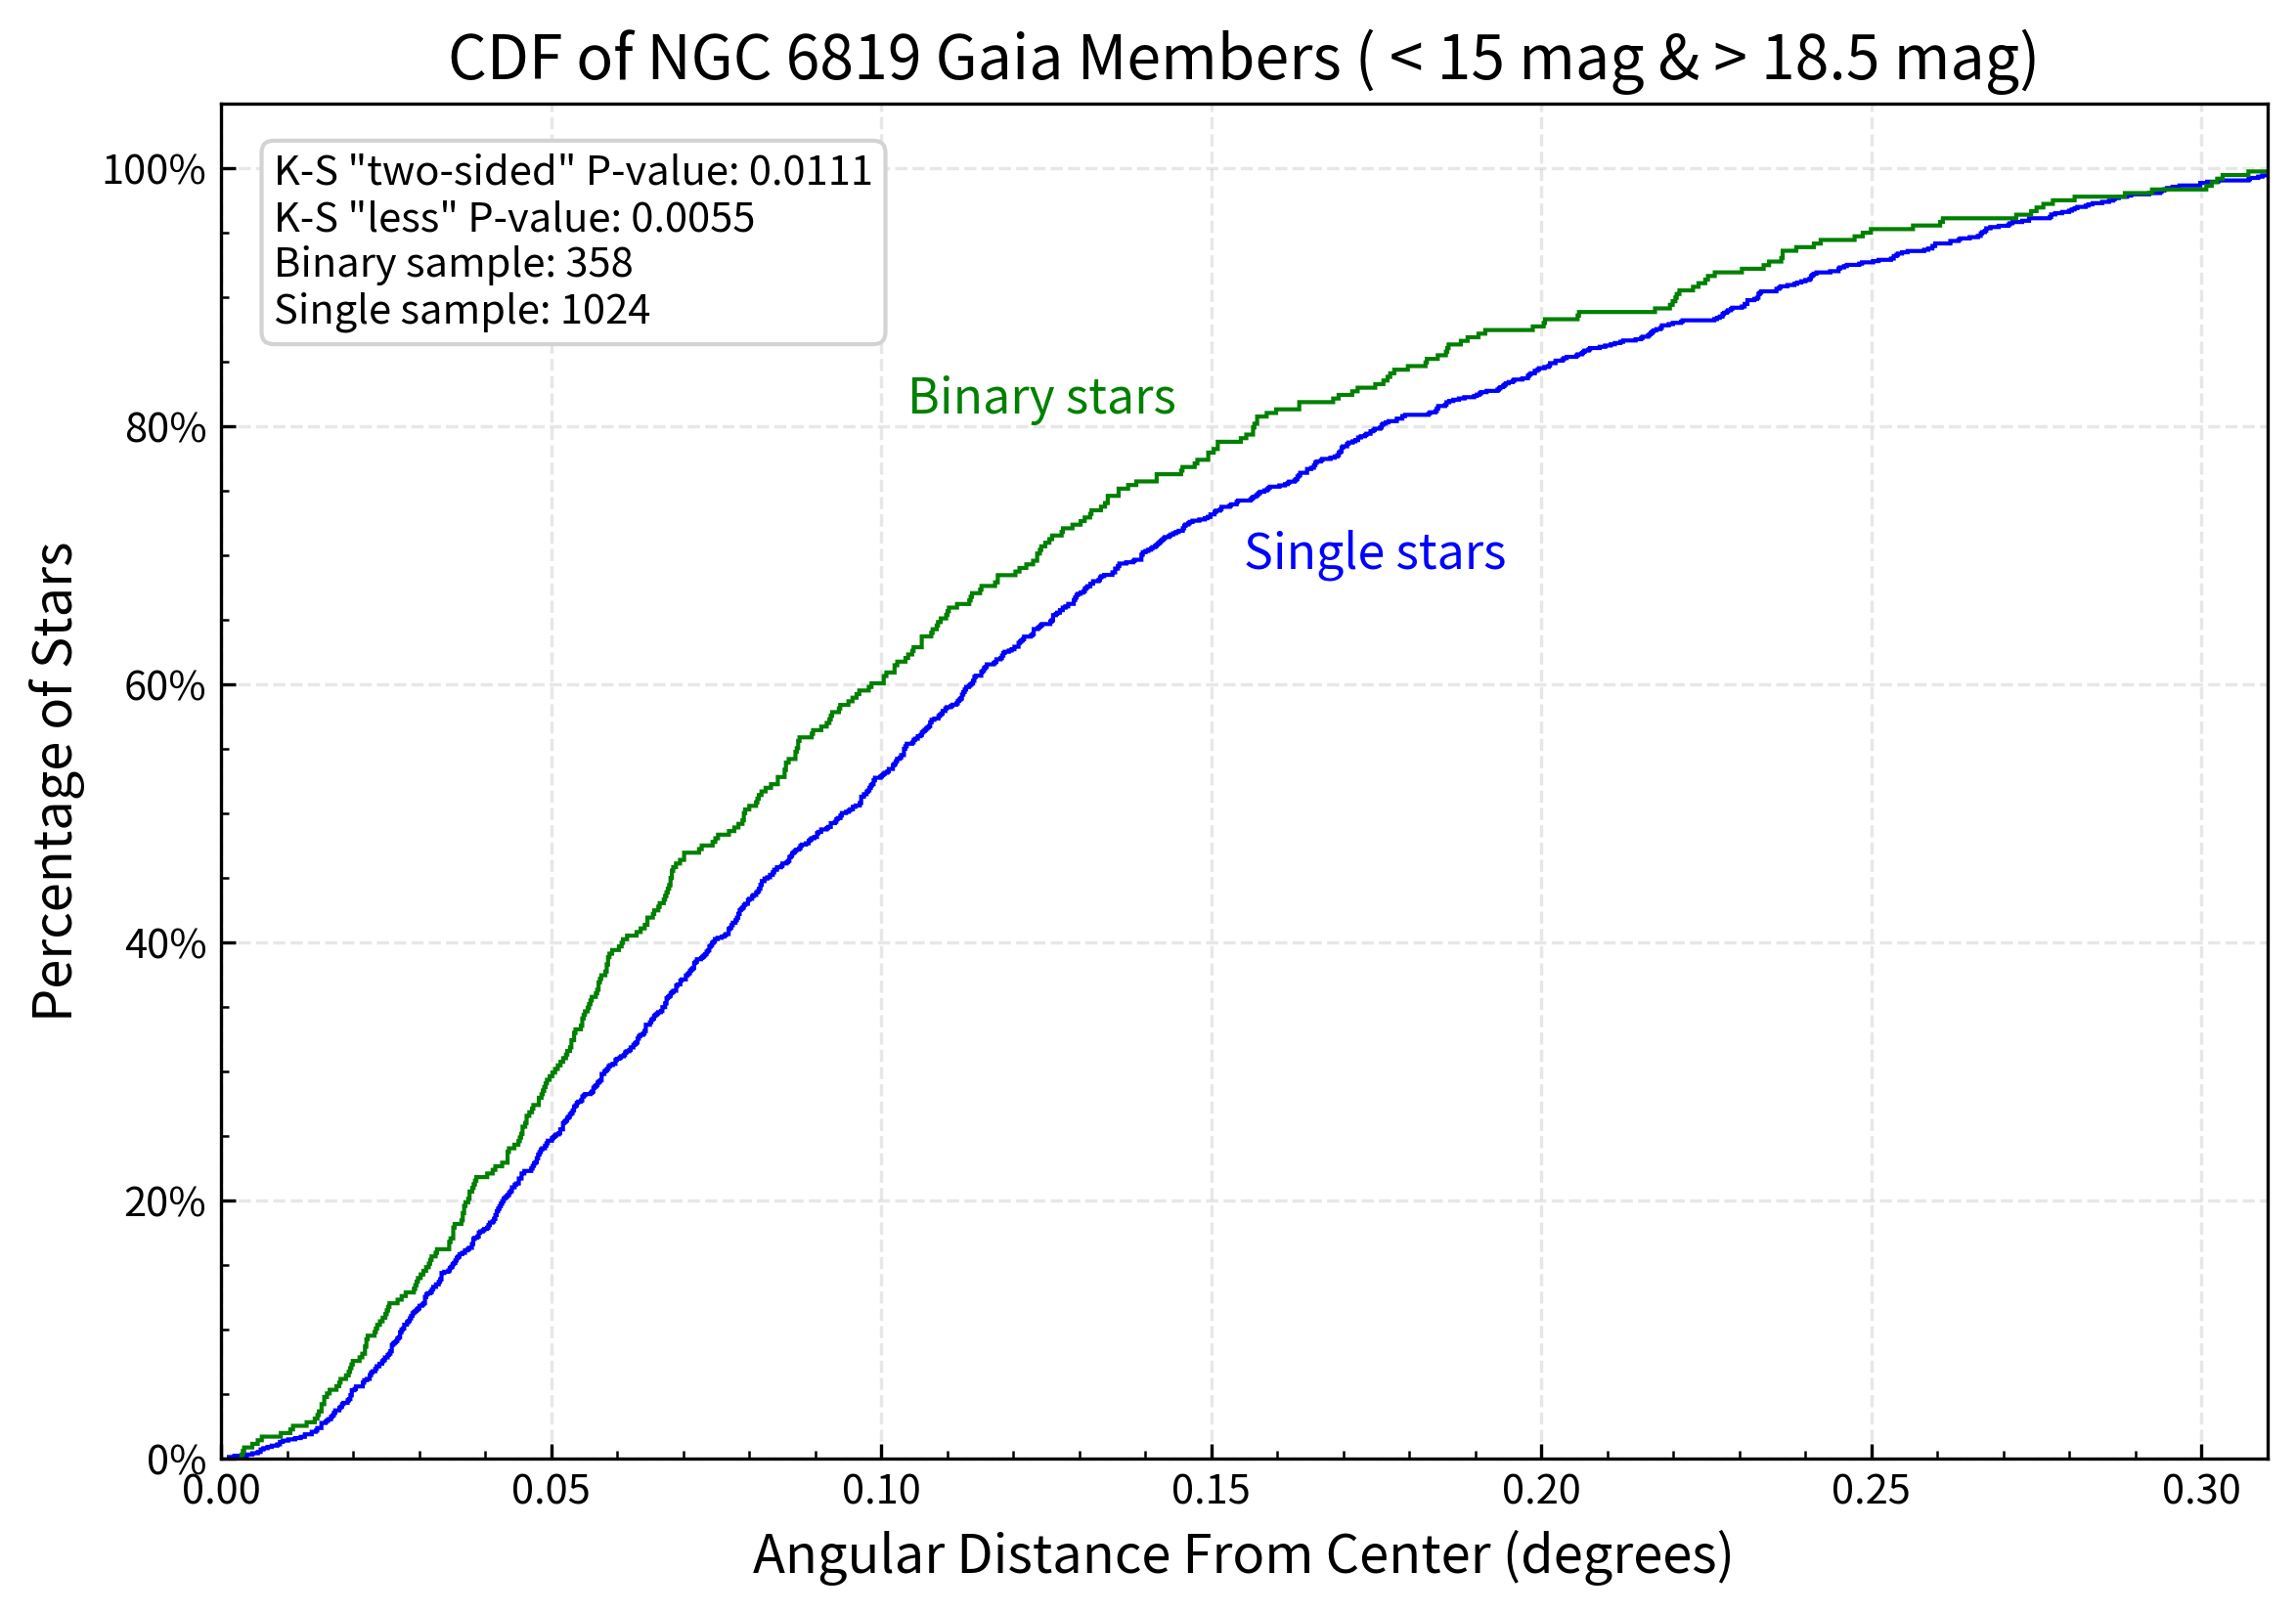

In [189]:
#topmag and bottommag CDF
f,ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)

single = cutSingleGaiaData['distance']
binary = cutBinaryGaiaData['distance']

ax.hist(single, cumulative = True, density = True, histtype = "step", bins = 1500, color='b')
ax.hist(binary, cumulative = True, density = True, histtype = "step", bins = 1500,color='g')

ks_result = ks_2samp(single,binary)
print(ks_result)

plt.xlabel("Angular Distance From Center (degrees)", fontsize=13)
plt.ylabel("Percentage of Stars", fontsize=13)
plt.title("CDF of NGC 6819 Gaia Members ( < 15 mag & > 18.5 mag)", fontsize=15)
plt.text(.008, .88, 'K-S "two-sided" P-value: 0.0111\nK-S "less" P-value: 0.0055\nBinary sample: 358\nSingle sample: 1024',fontsize = 10, 
         bbox = dict(facecolor='w', boxstyle='round', edgecolor='lightgray'))
custom_lines = [ Line2D([0], [0], color='g',alpha=1, lw=2, ls='-'),
                                Line2D([0], [0], color='b',alpha=1, lw=2, ls='-')]
plt.grid(linestyle='--', alpha=0.3)
#plt.legend(custom_lines, ['Binary stars', 'Single stars'],loc=2, fontsize=10)
plt.annotate(text="Binary stars", color='g', xy=(.104,.81), xytext=(.104,.81), size=12)
plt.annotate(text="Single stars", color='b', xy=(.155,.69), xytext=(.155,.69), size=12)
from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
ax.yaxis.get_ticklocs(minor=True)
ax.minorticks_on()
ax.tick_params(which='both', direction="in")
ax.set_xlim(0,.31)
plt.show()

In [190]:
Nbins= np.linspace(0.8, 1.4, 8)

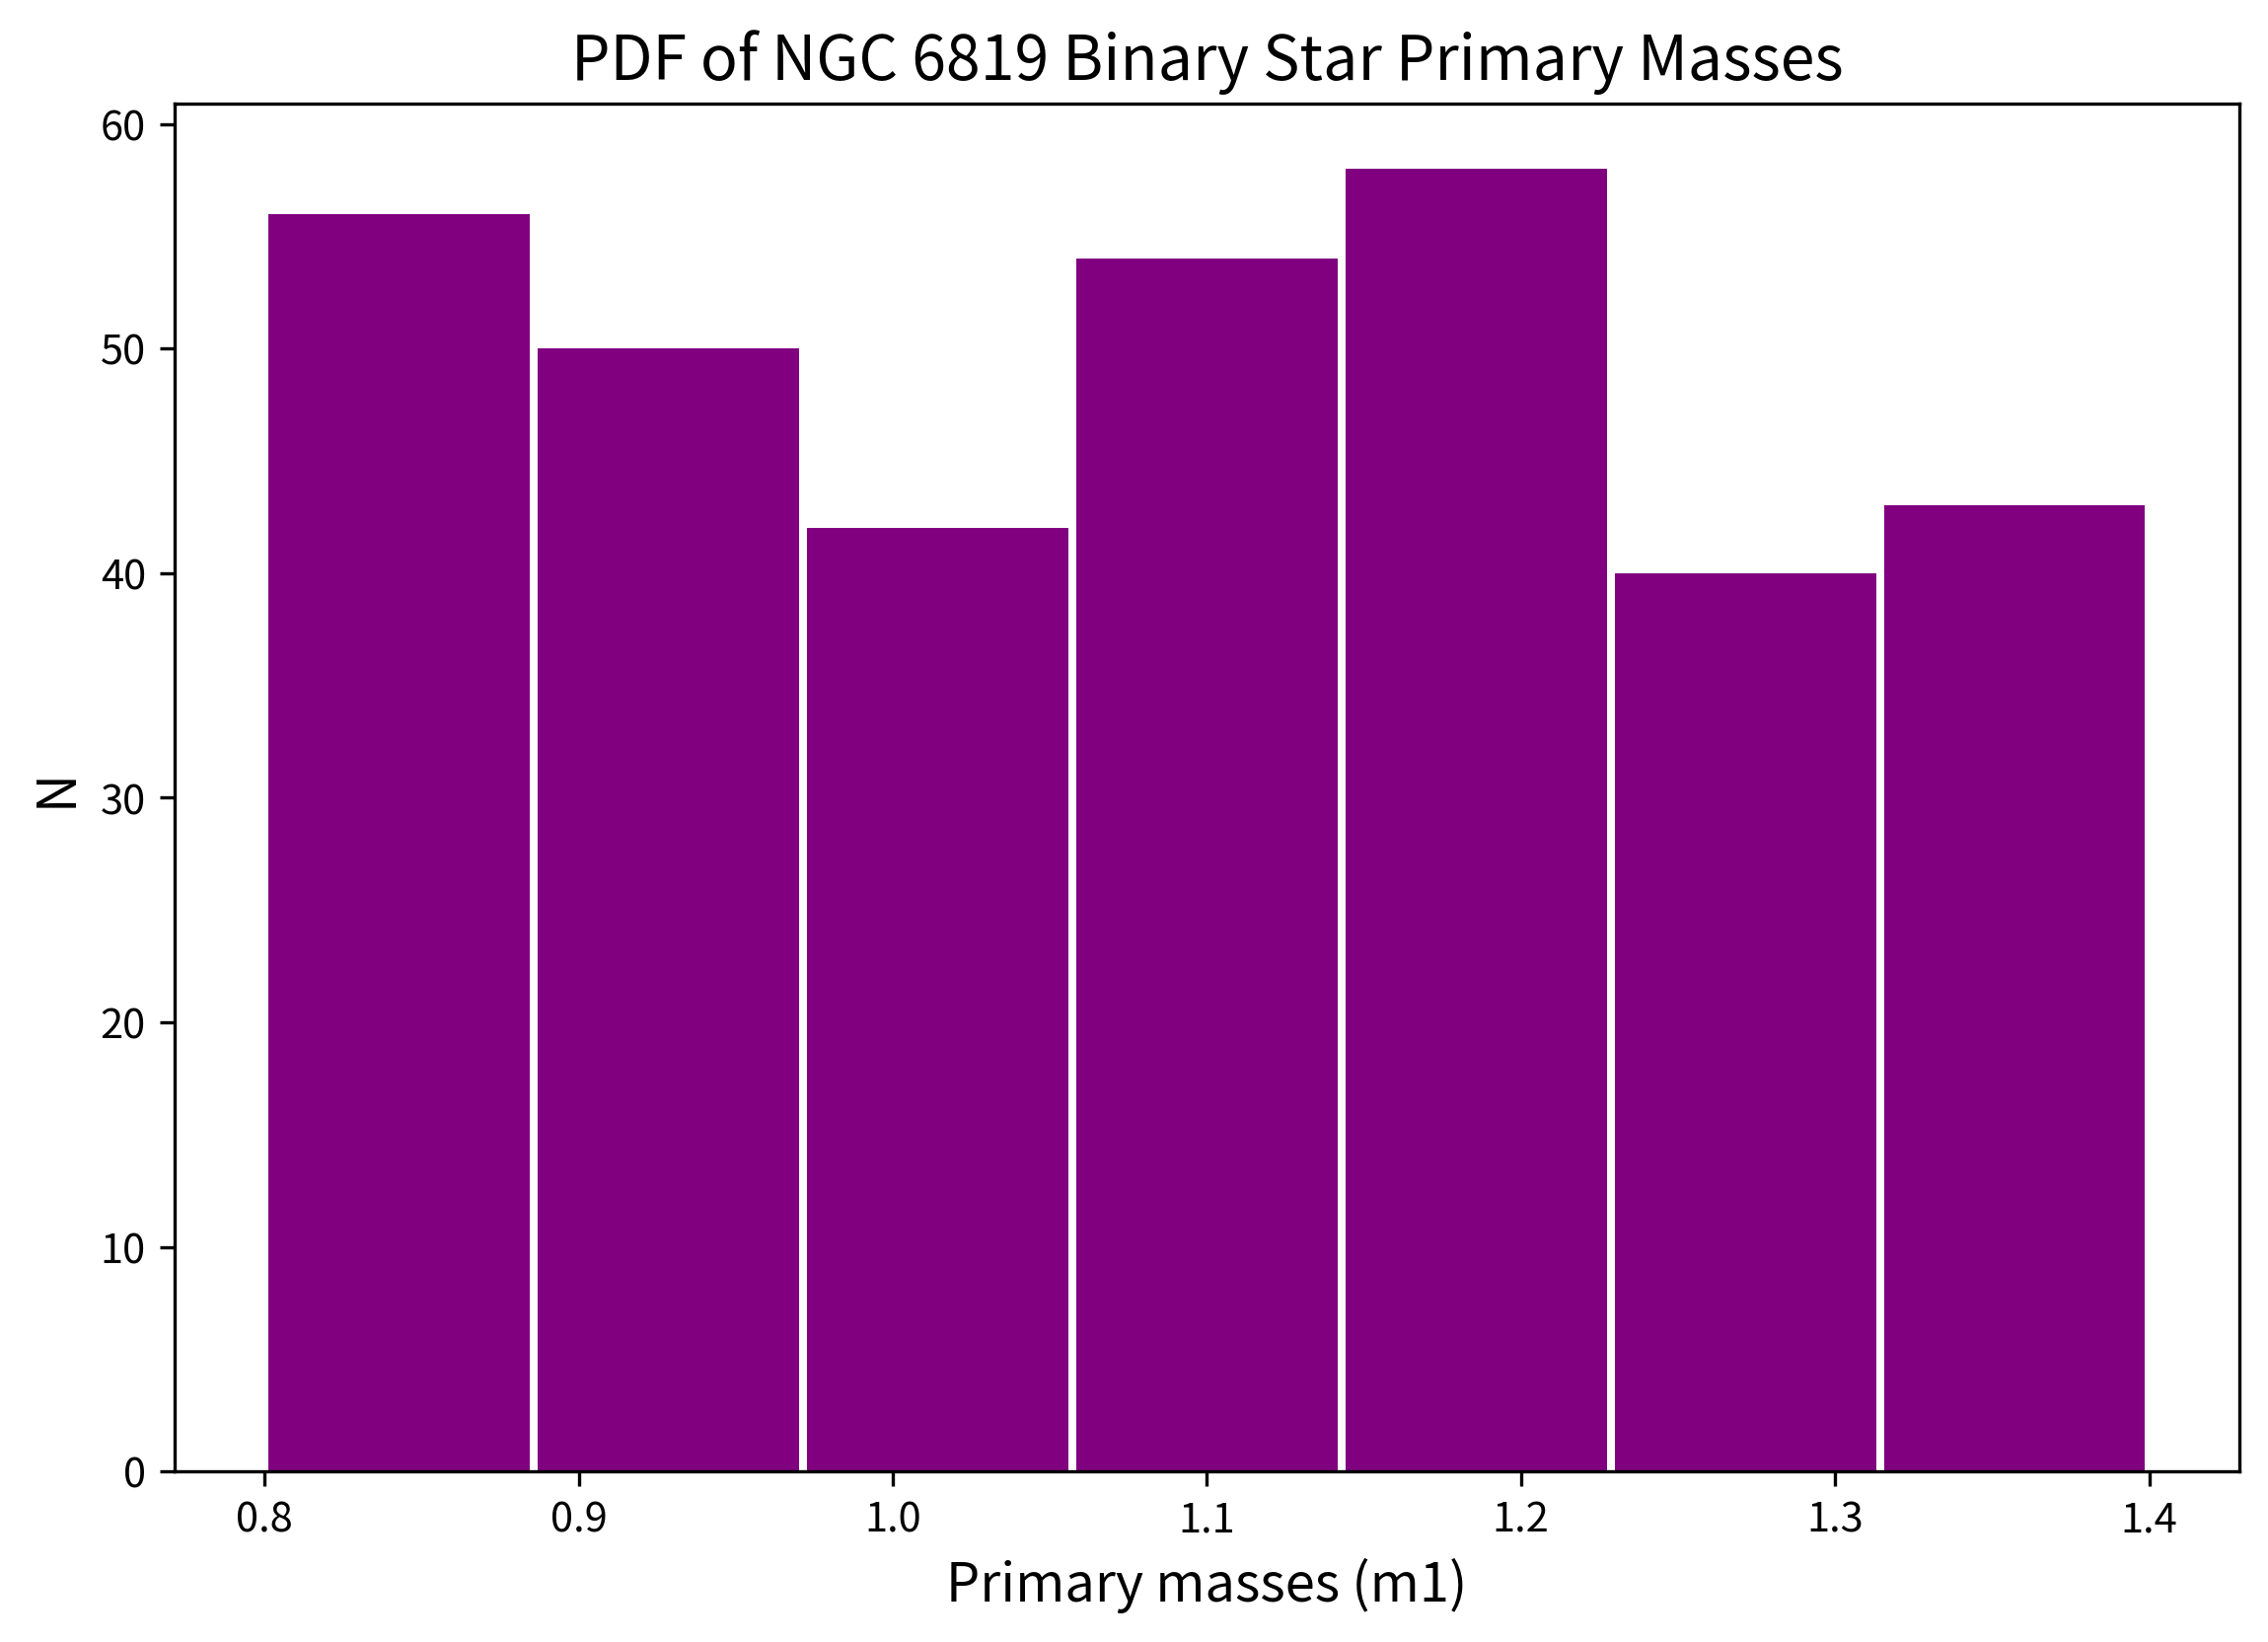

In [191]:
f,ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)
counts1, bins1, bars1 = plt.hist(binaryGaiaData['m1Mean'],Nbins, linewidth=2,color='purple',rwidth=0.97)
plt.ylabel('N',fontsize=13)
plt.xlabel('Primary masses (m1)',fontsize=13)
plt.title('PDF of NGC 6819 Binary Star Primary Masses', fontsize=15)
plt.show()

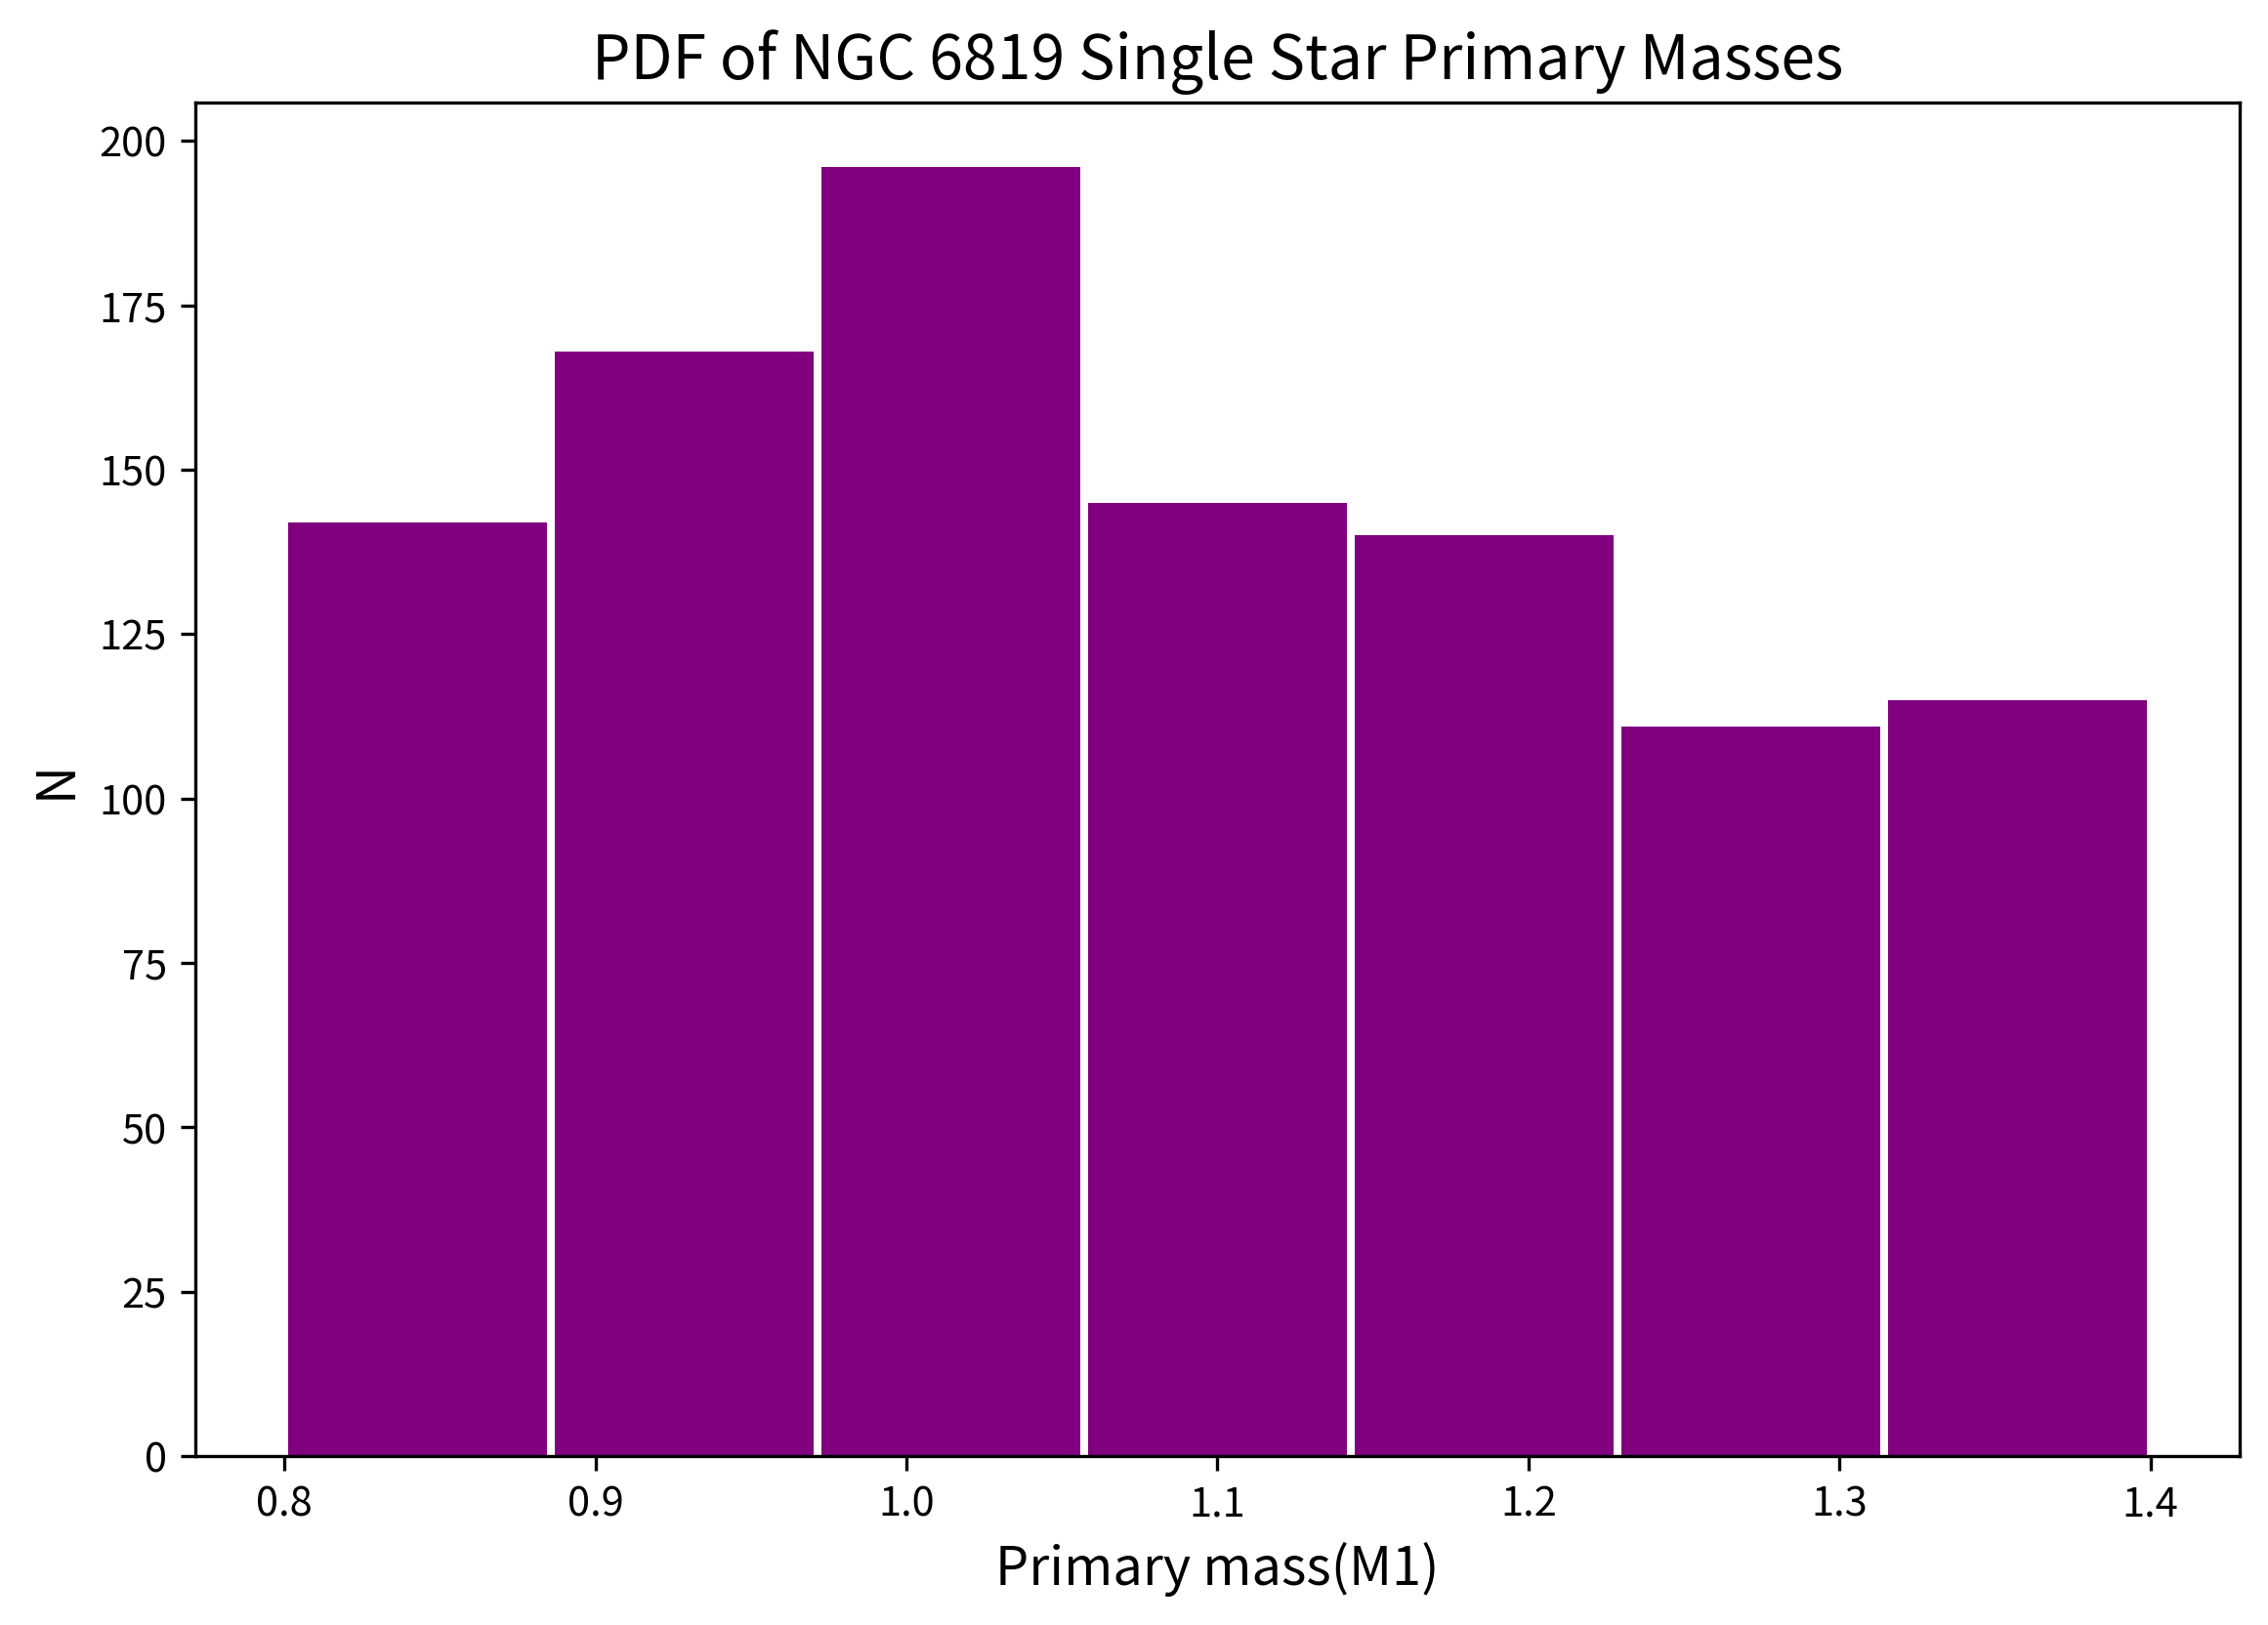

In [192]:
f,ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)
counts2, bins2, bars2 = plt.hist(singleGaiaData['m1Mean'],Nbins, linewidth=2,color='purple',rwidth=0.97)
plt.ylabel('N',fontsize=13)
plt.xlabel('Primary mass(M1)',fontsize=13)
plt.title('PDF of NGC 6819 Single Star Primary Masses', fontsize=15)
plt.show()

In [193]:
errors_y3 = np.sqrt(counts1)/counts2
print(errors_y3)

[0.0526994  0.04208969 0.033065   0.0506791  0.05439838 0.05697798
 0.0570212 ]


In [194]:
print(bins1)
#find halfway point between first and second bin
print(bins1 + (bins1[1]-bins1[0])/2 )
print(bins1[1]-bins1[0],bins1[2]-bins1[1])

print(len(bins1), len(counts1/counts2))

[0.8        0.88571429 0.97142857 1.05714286 1.14285714 1.22857143
 1.31428571 1.4       ]
[0.84285714 0.92857143 1.01428571 1.1        1.18571429 1.27142857
 1.35714286 1.44285714]
0.08571428571428574 0.08571428571428563
8 7


[0.8        0.88571429 0.97142857 1.05714286 1.14285714 1.22857143
 1.31428571 1.4       ] [0.8        0.88571429 0.97142857 1.05714286 1.14285714 1.22857143
 1.31428571 1.4       ]


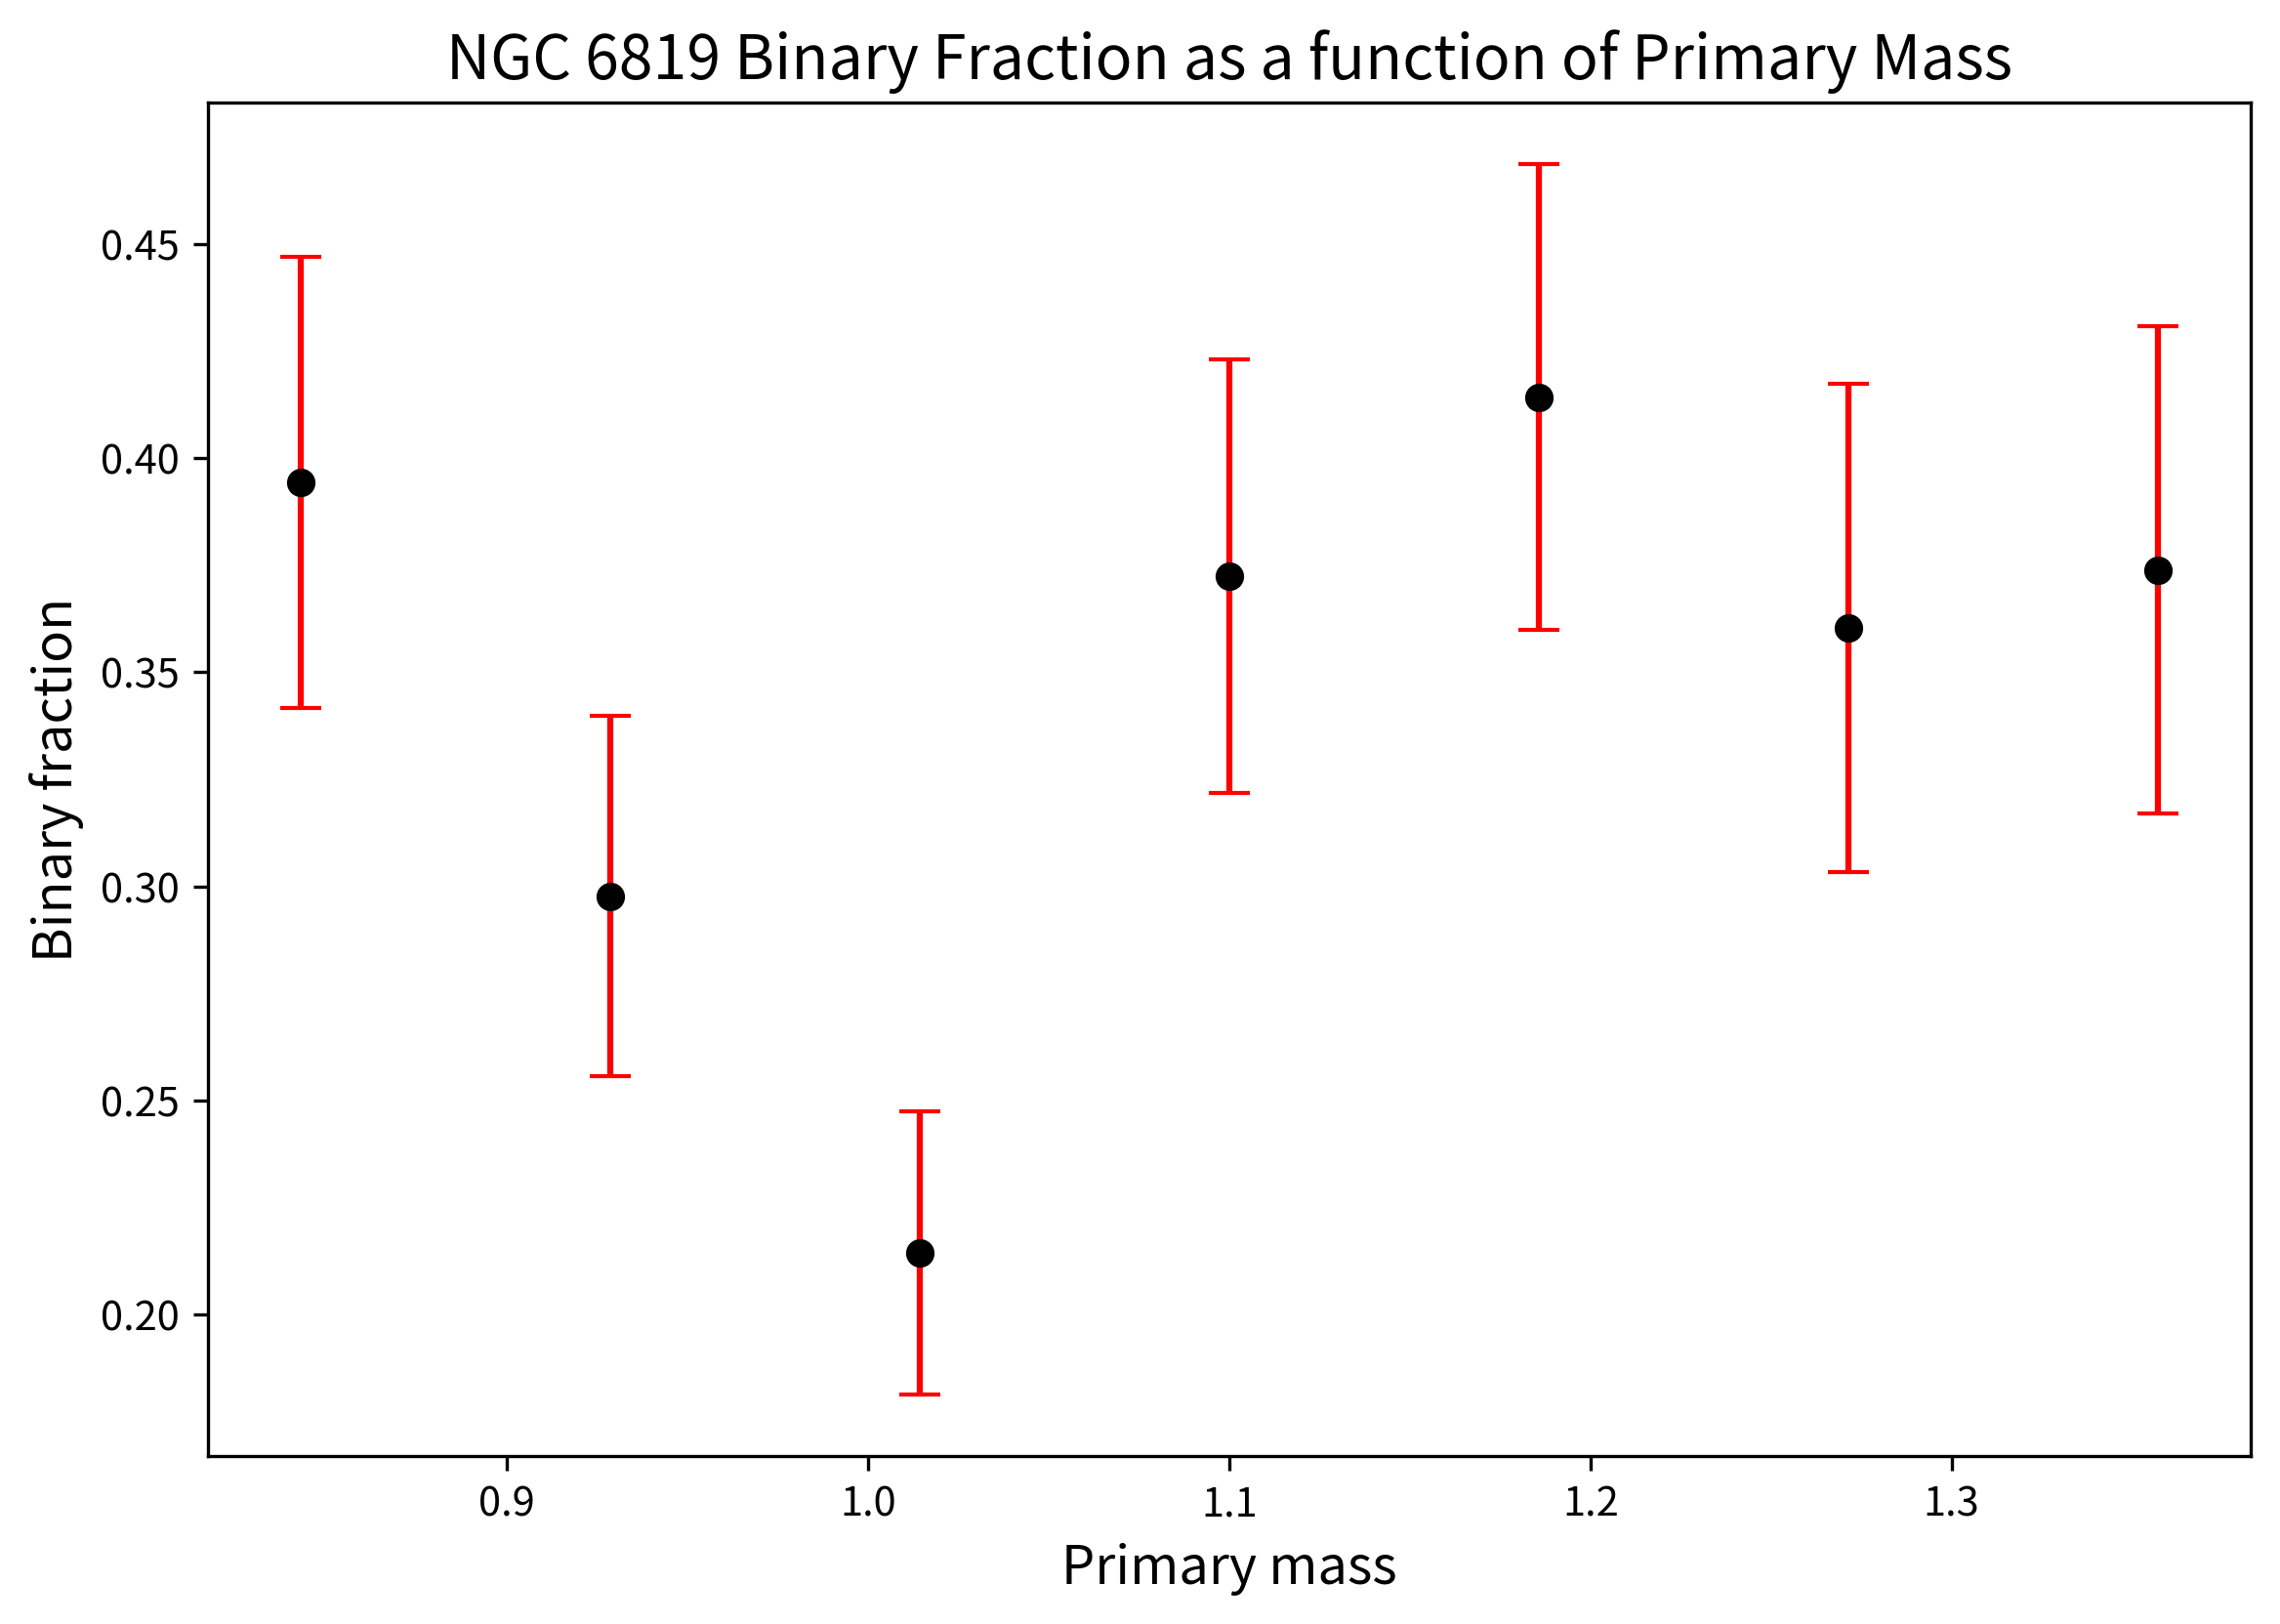

In [195]:
f,ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)
print(bins1,bins2)
primarybins = bins1[:-1] + (bins1[1]-bins1[0])/2

plt.errorbar(primarybins, counts1/counts2, xerr=None, yerr=errors_y3, fmt='o',capsize=5, color='black', ecolor='red')
plt.ylabel('Binary fraction',fontsize=13)
plt.xlabel('Primary mass',fontsize=13)
plt.title('NGC 6819 Binary Fraction as a function of Primary Mass', fontsize=15)
plt.show()

In [196]:
counts2

array([142., 168., 196., 145., 140., 111., 115.])

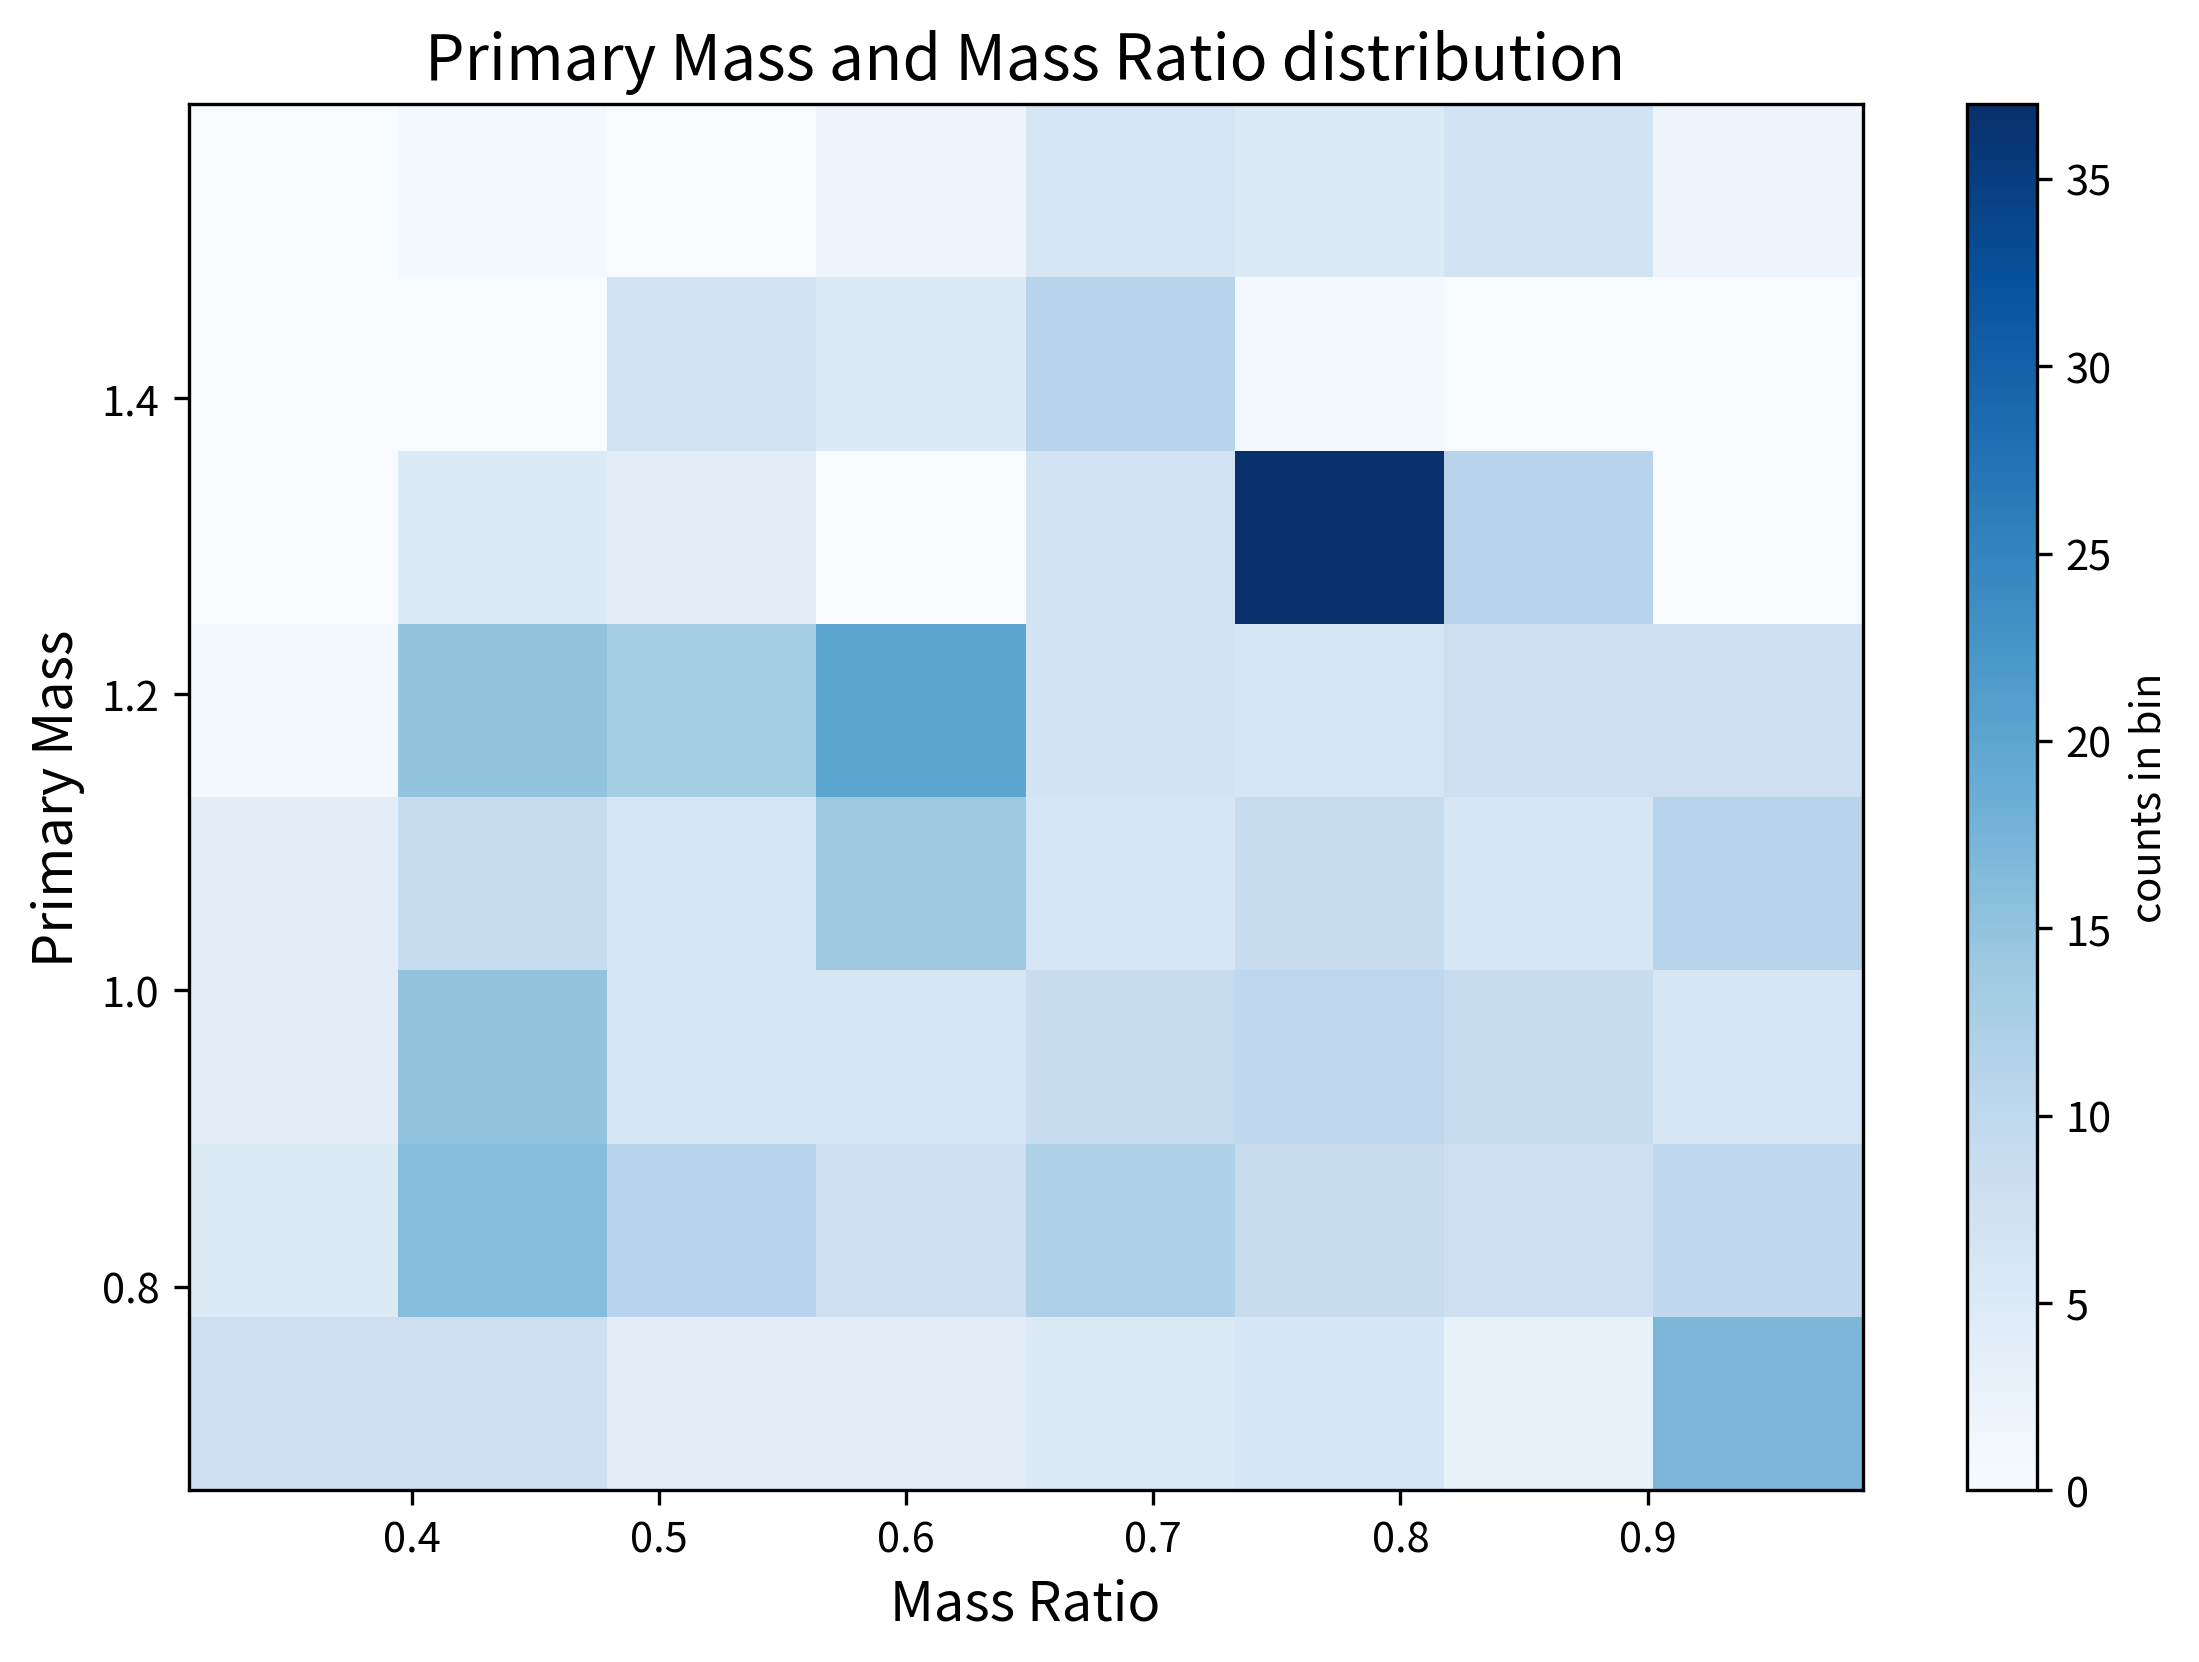

In [197]:
f,ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)
plt.hist2d(binaryGaiaData['qMean'], binaryGaiaData['m1Mean'], bins=8, cmap='Blues')
cb = plt.colorbar(label='counts in bin')
plt.xlabel('Mass Ratio',fontsize=13)
plt.ylabel('Primary Mass',fontsize=13)
plt.title("Primary Mass and Mass Ratio distribution", fontsize=15)
plt.show()

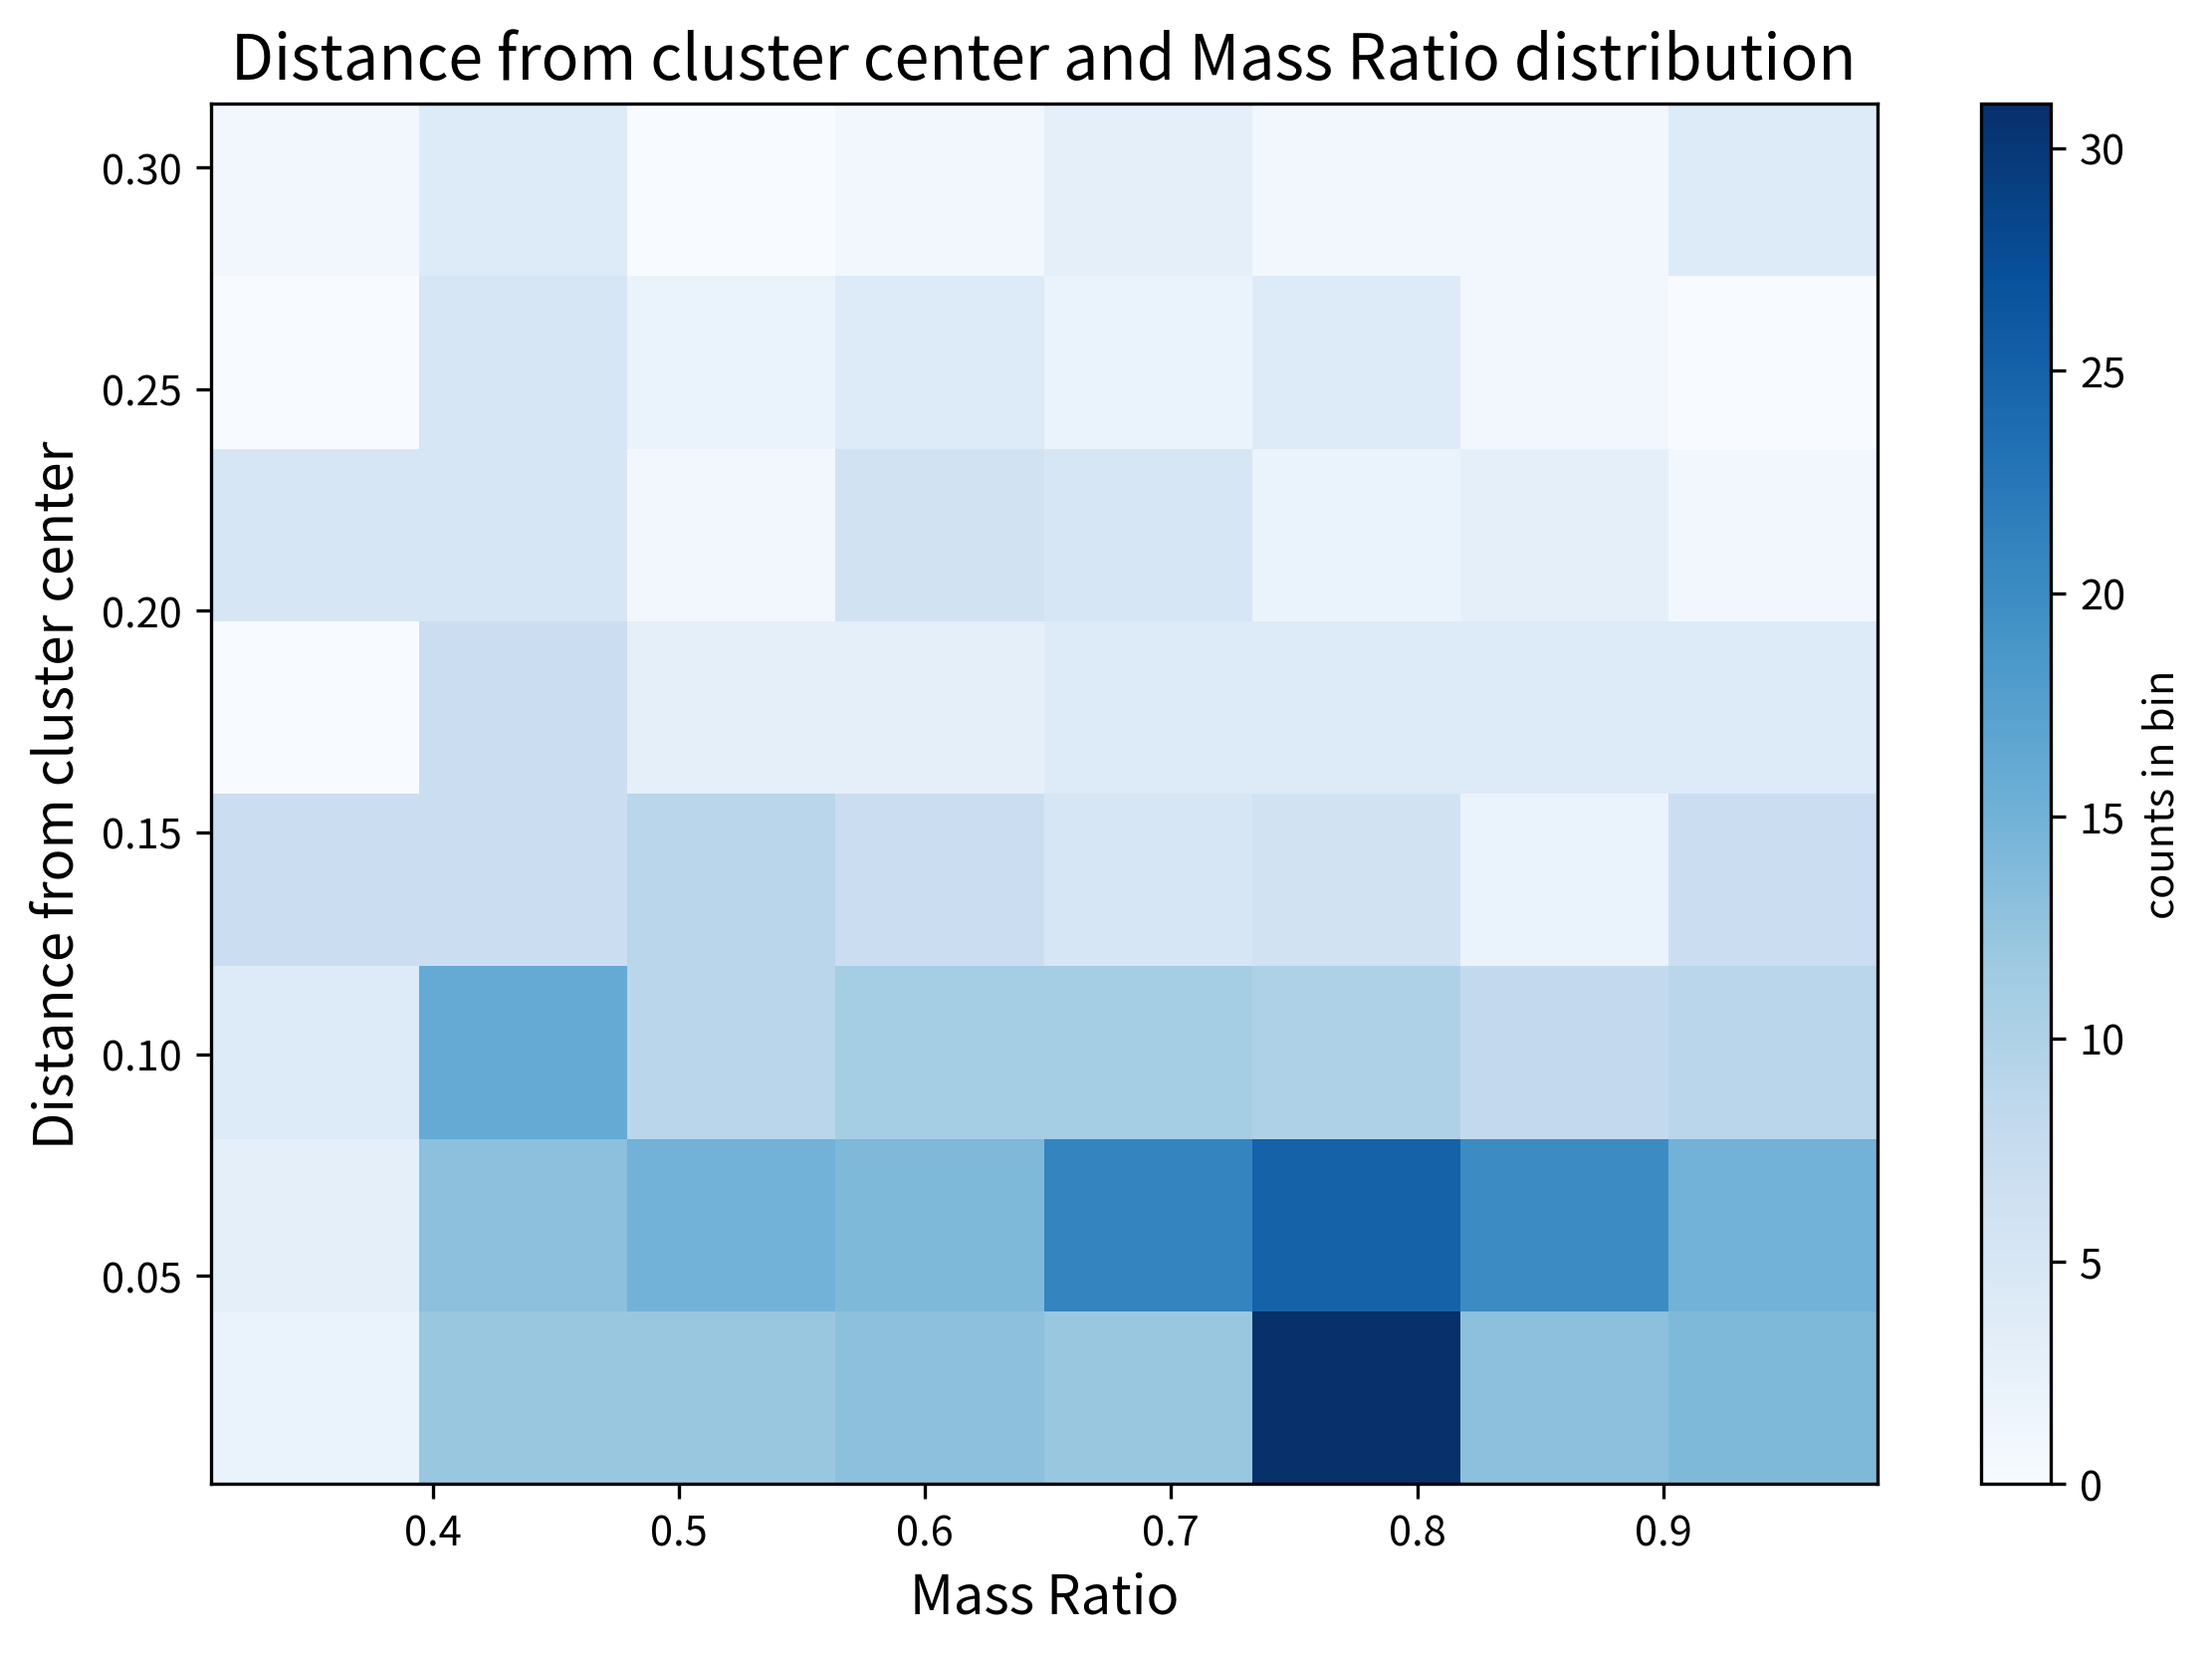

In [198]:
#qmean and distance
f,ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)
plt.hist2d(binaryGaiaData['qMean'], binaryGaiaData['distance'], bins=8, cmap='Blues')
cb = plt.colorbar(label='counts in bin')
plt.xlabel('Mass Ratio',fontsize=13)
plt.ylabel('Distance from cluster center',fontsize=13)
plt.title("Distance from cluster center and Mass Ratio distribution", fontsize=15)
plt.show()

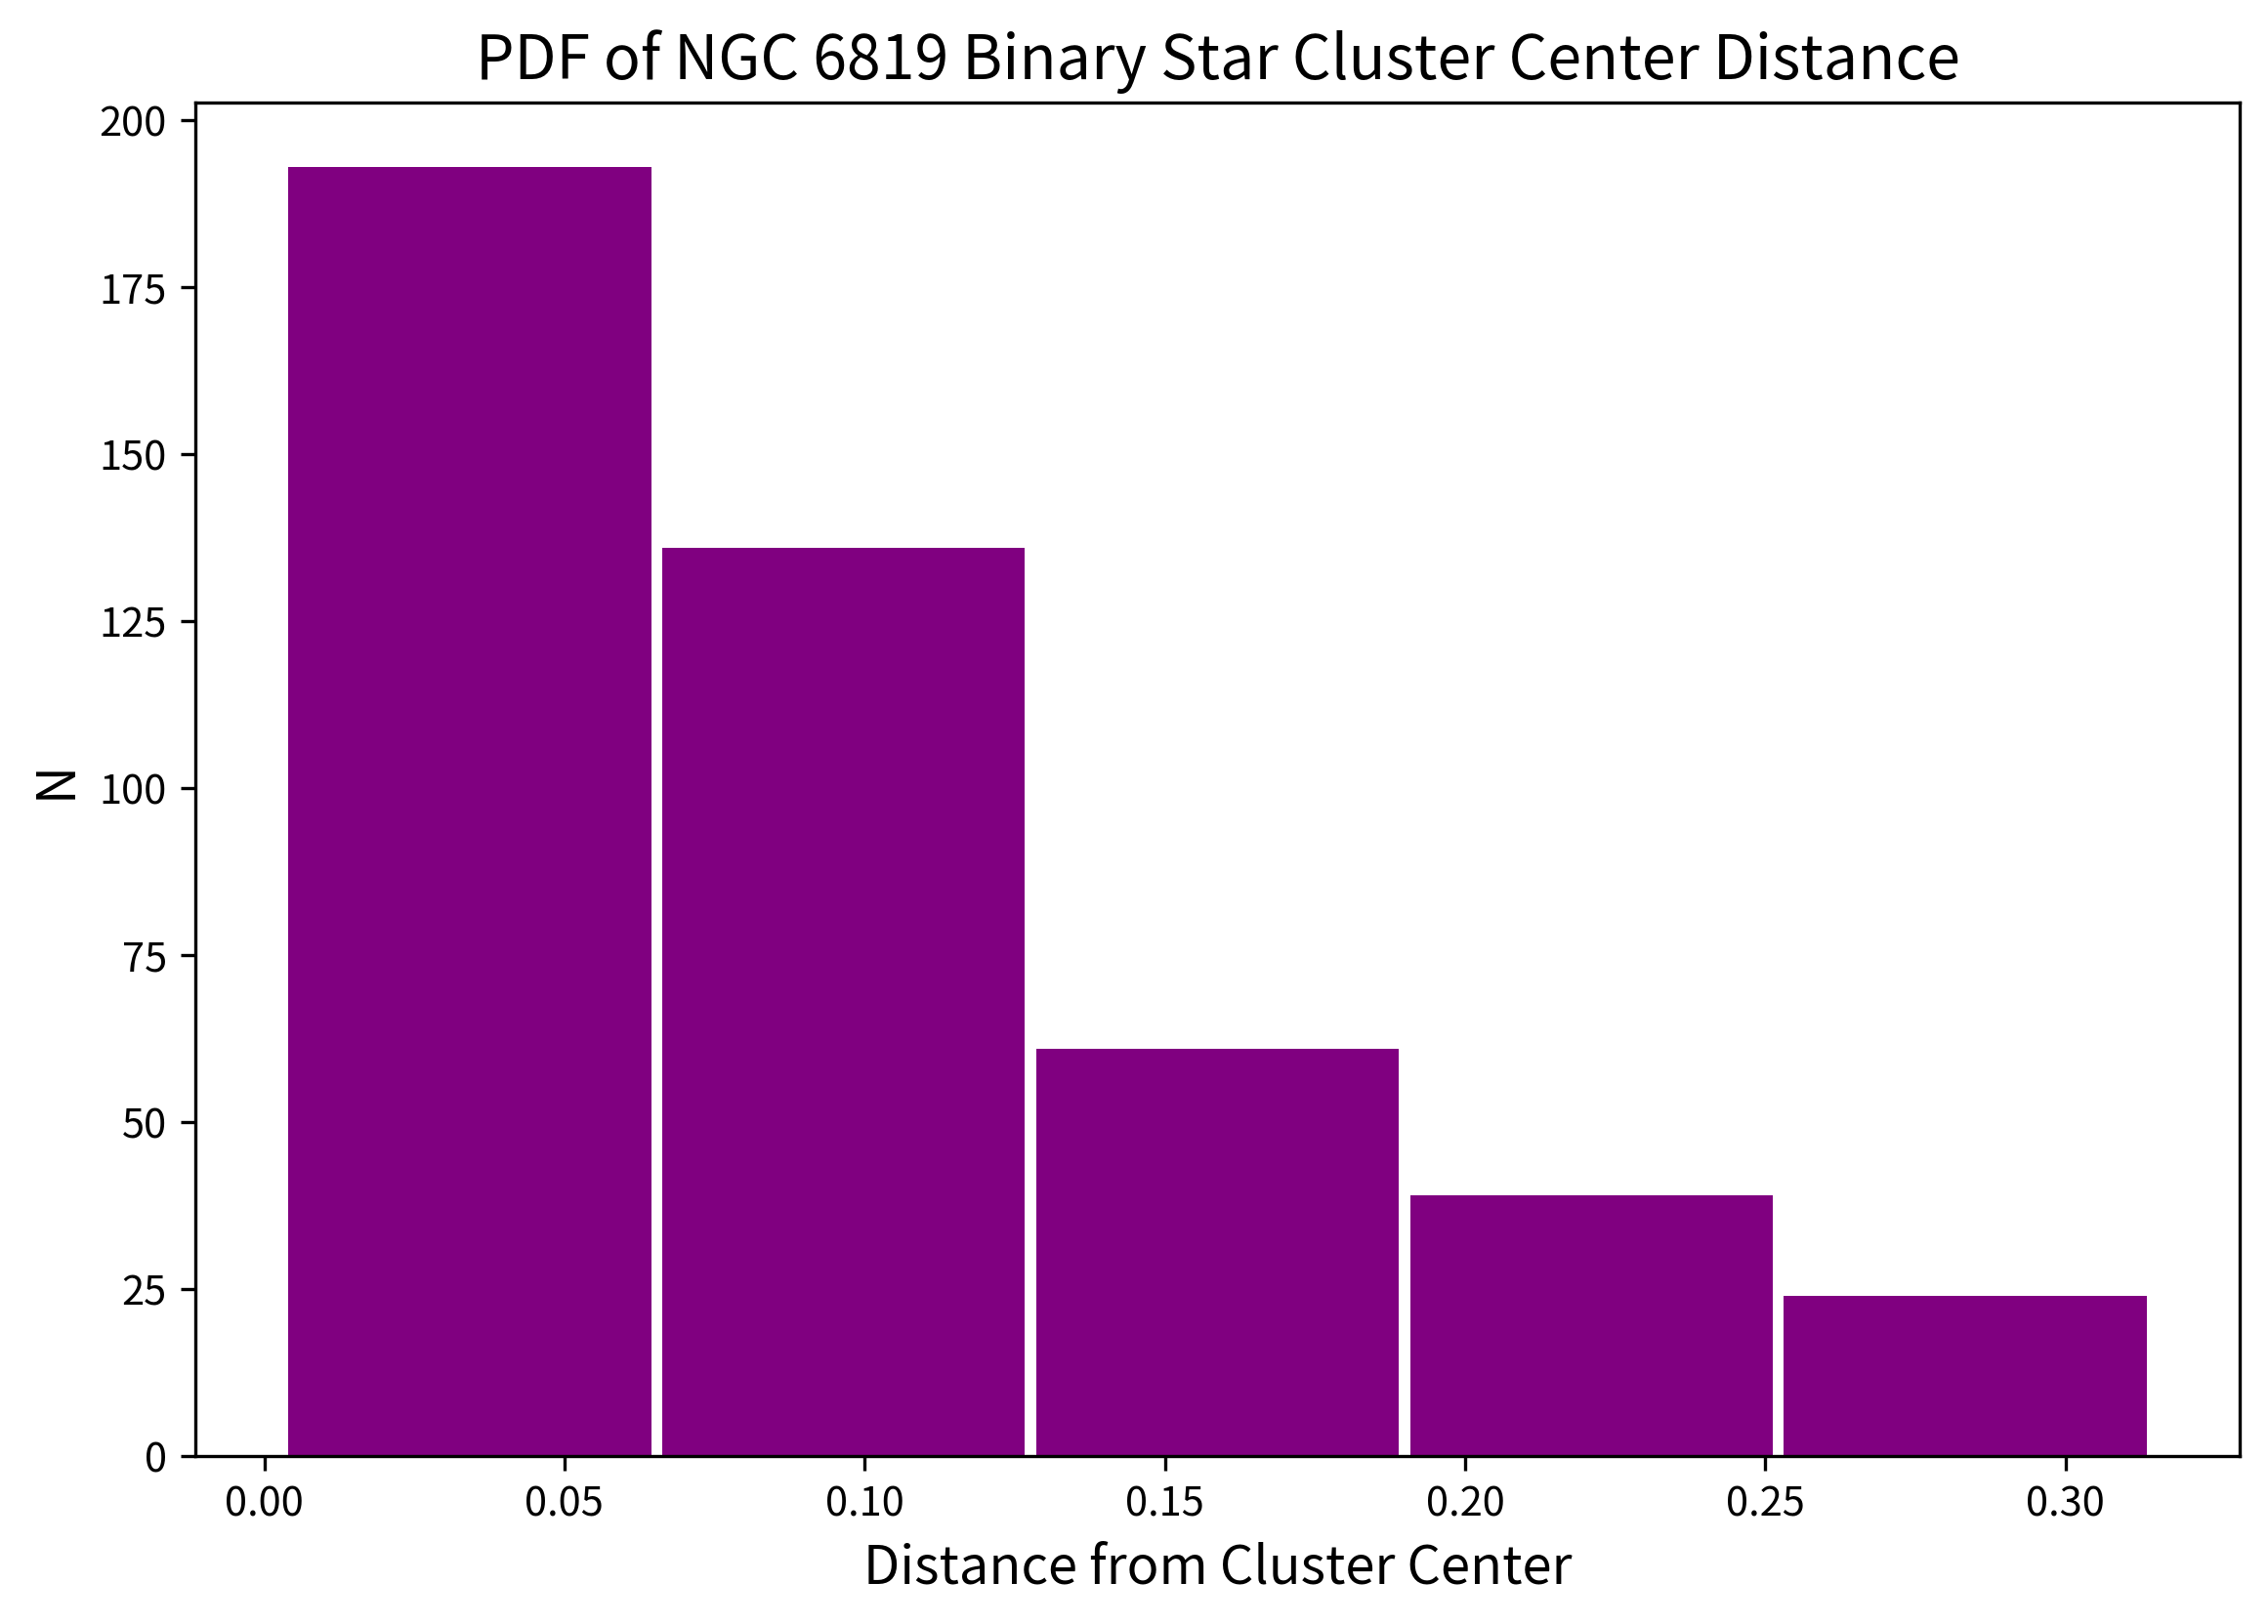

In [199]:
f,ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)
counts, bins, bars =plt.hist(binaryGaiaData['distance'], bins=5,linewidth=2,color='purple',rwidth=0.97)
plt.xlabel('Distance from Cluster Center',fontsize=13)
plt.ylabel('N',fontsize=13)
plt.title("PDF of NGC 6819 Binary Star Cluster Center Distance", fontsize=15)
plt.show()

TypeError: title() missing 1 required positional argument: 'label'

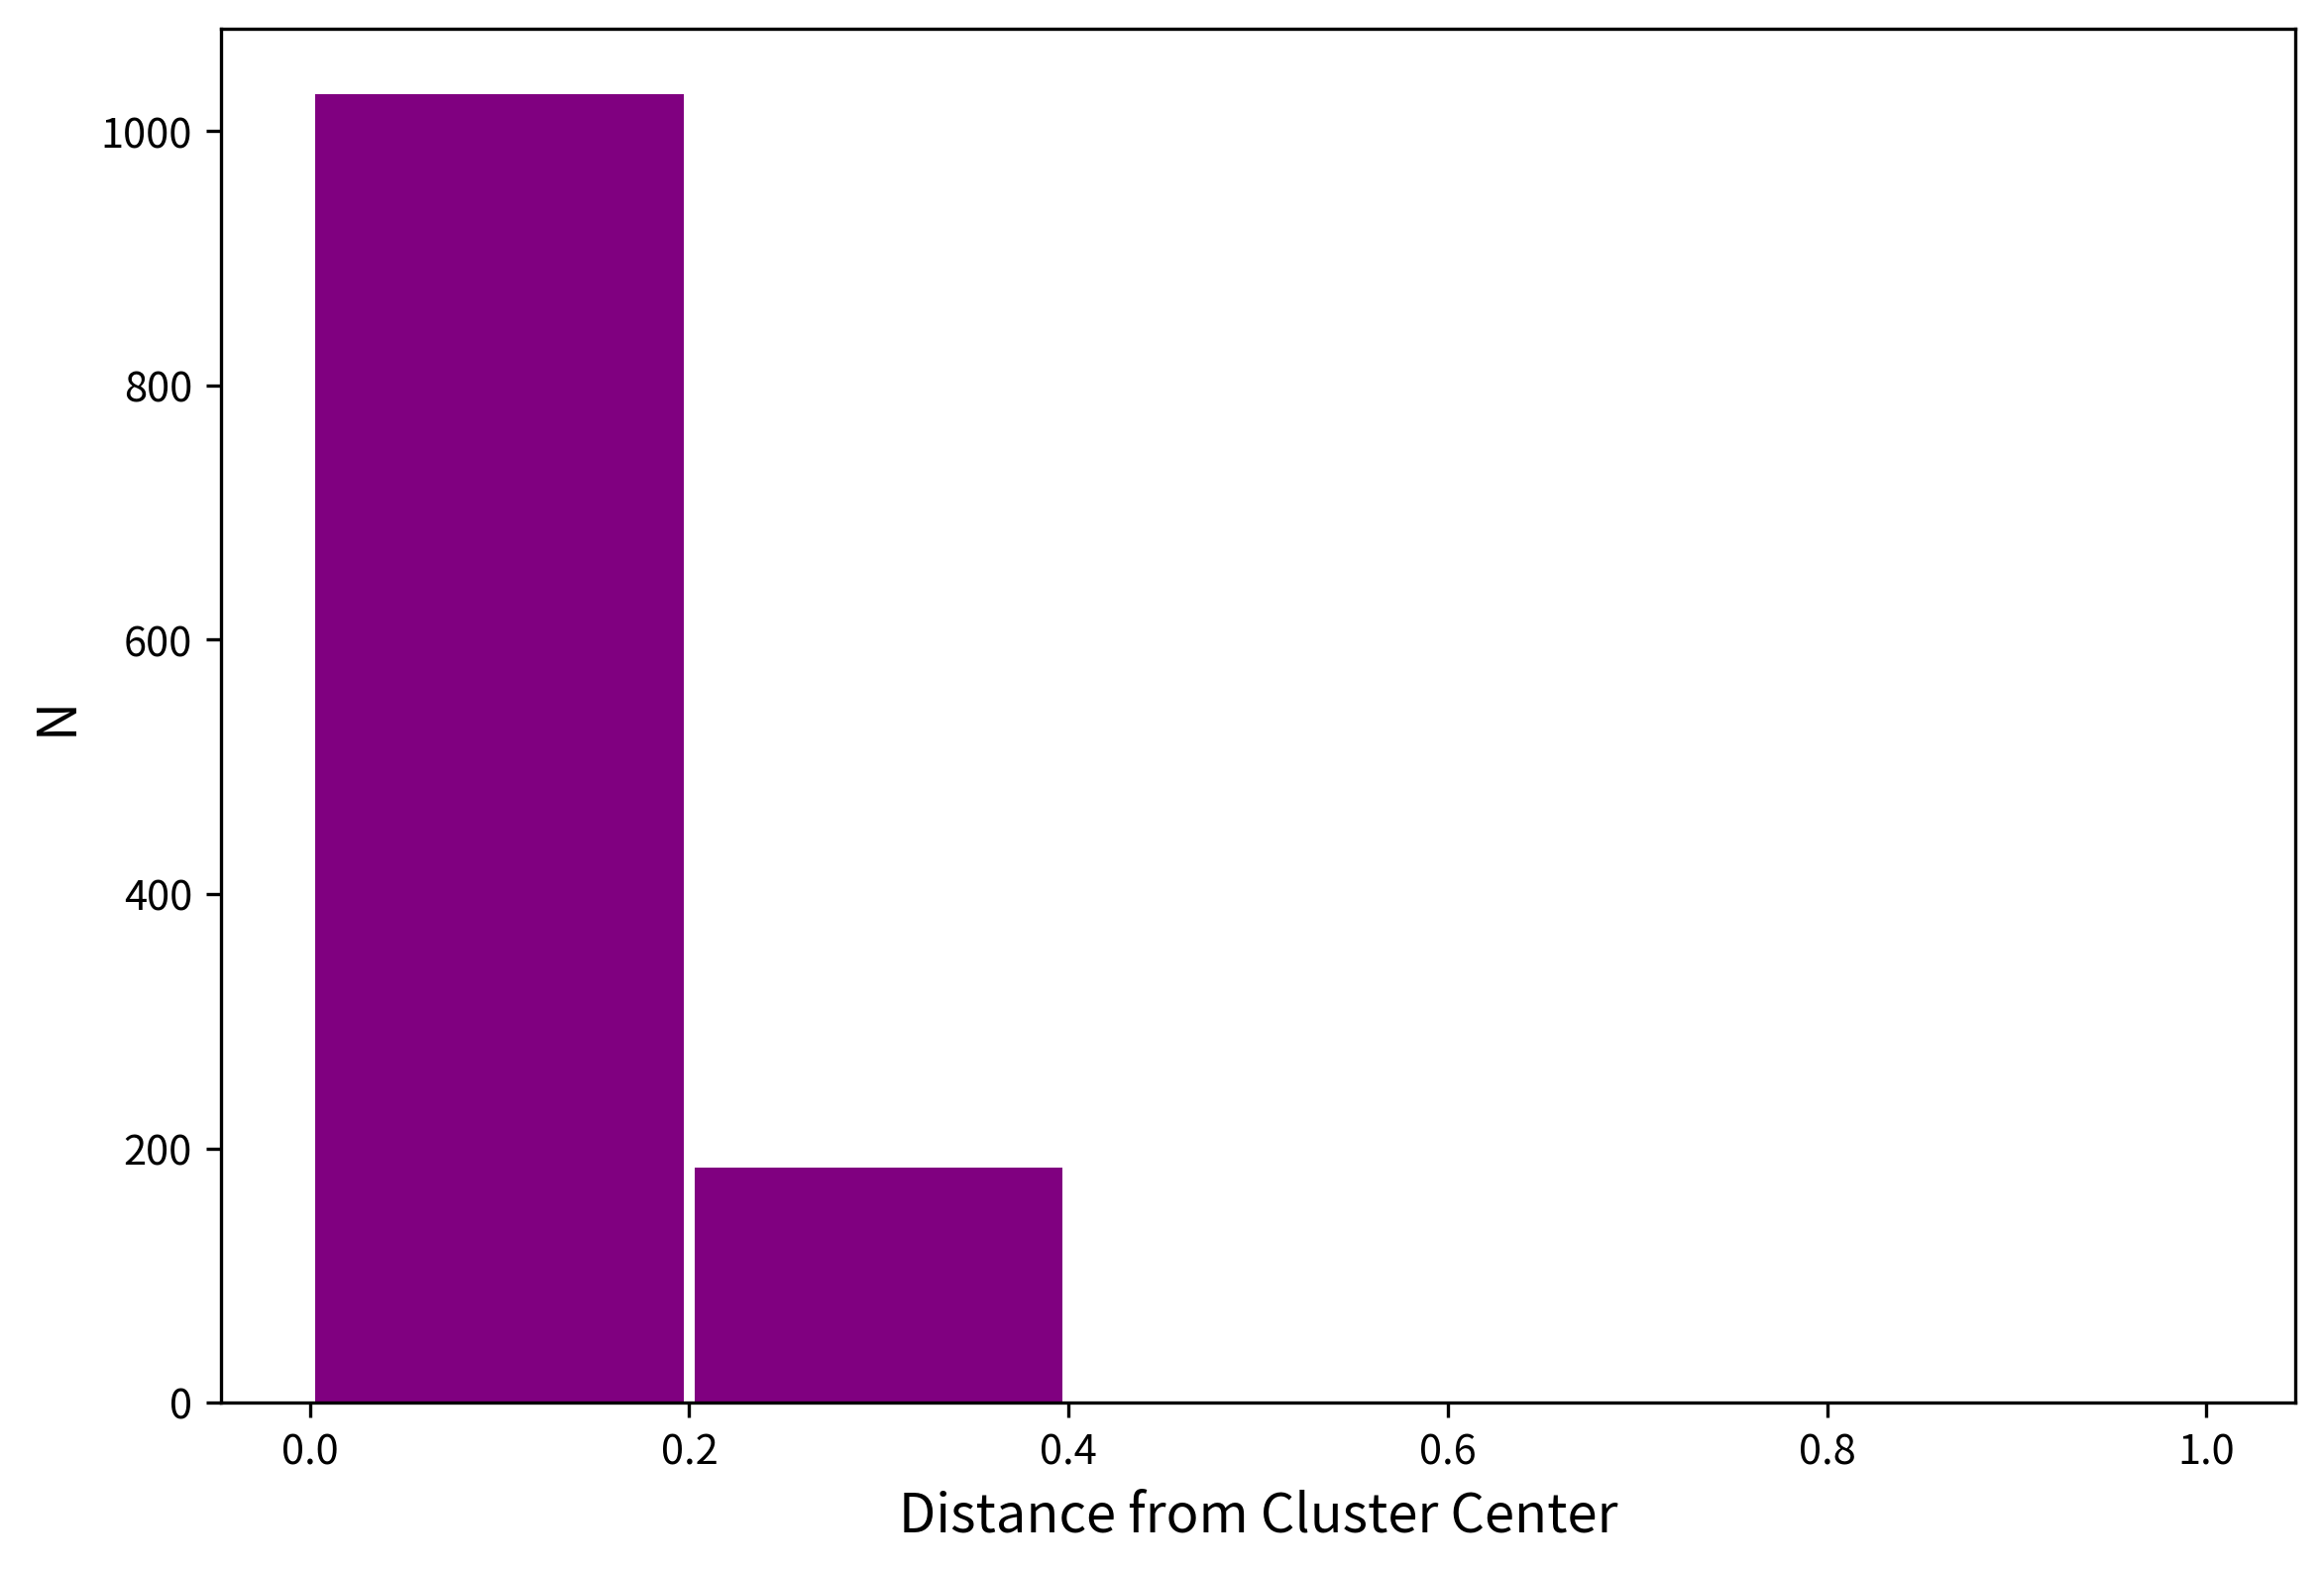

In [200]:
f,ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)
counts2, bins2, bars2 = plt.hist(singleGaiaData['distance'], bins=5, range=[0,1],linewidth=2,color='purple',rwidth=0.97)
plt.xlabel('Distance from Cluster Center',fontsize=13)
plt.ylabel('N',fontsize=13)
plt.title()
plt.show()

In [ ]:
bins

array([0.00309573, 0.06535558, 0.12761543, 0.18987528, 0.25213514,
       0.31439499])

In [ ]:
# is this the right way to do error? can we factor in the std of the values themselves?
errors_y = np.sqrt(counts)/counts2


/var/folders/_w/2tvx5cms23s29hpbx7ncw_cr0000gn/T/ipykernel_5821/847706480.py:2: RuntimeWarning: divide by zero encountered in divide
  errors_y = np.sqrt(counts)/counts2


/var/folders/_w/2tvx5cms23s29hpbx7ncw_cr0000gn/T/ipykernel_5821/3076053262.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(bins3, counts/counts2, color='blue')


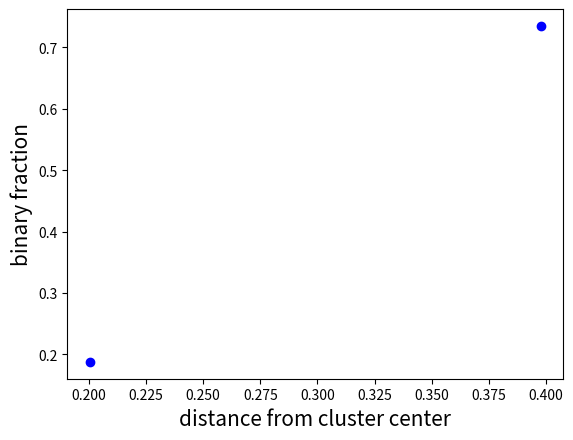

In [ ]:
bins3 = [ 0.20038481, 0.39769111, 0.5949974 , 0.79230369,
       0.98960999 ]

plt.xlabel('distance from cluster center',fontsize=15)
plt.ylabel('binary fraction',fontsize=15)
plt.scatter(bins3, counts/counts2, color='blue')

/var/folders/_w/2tvx5cms23s29hpbx7ncw_cr0000gn/T/ipykernel_5821/2229133871.py:3: RuntimeWarning: divide by zero encountered in divide
  plt.errorbar(bins3, counts/counts2, xerr=None, yerr=errors_y, fmt='o',capsize=5, color='black', ecolor='red')
/Users/Claire/opt/anaconda3/envs/BASE9/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3593: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err


<ErrorbarContainer object of 3 artists>

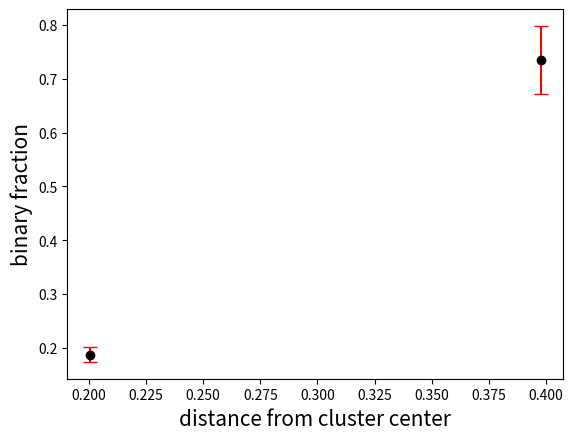

In [ ]:
plt.xlabel('distance from cluster center',fontsize=15)
plt.ylabel('binary fraction',fontsize=15)
plt.errorbar(bins3, counts/counts2, xerr=None, yerr=errors_y, fmt='o',capsize=5, color='black', ecolor='red')

## plots of Only the center of CMD  13-17

Text(0.5, 0, 'Primary mass(M1) cut')

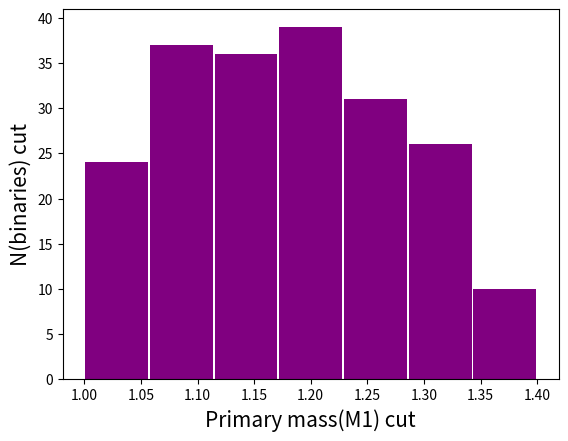

In [ ]:
counts5, bins5, bars5 = plt.hist(cutBinaryGaiaData['m1Mean'],bins=np.linspace(1,1.4, 8), linewidth=2,color='purple',rwidth=0.97)
plt.ylabel('N(binaries) cut',fontsize=15)
plt.xlabel('Primary mass(M1) cut',fontsize=15)

In [ ]:
bins5

array([1.        , 1.05714286, 1.11428571, 1.17142857, 1.22857143,
       1.28571429, 1.34285714, 1.4       ])

Text(0.5, 0, 'Primary mass(M1) cut')

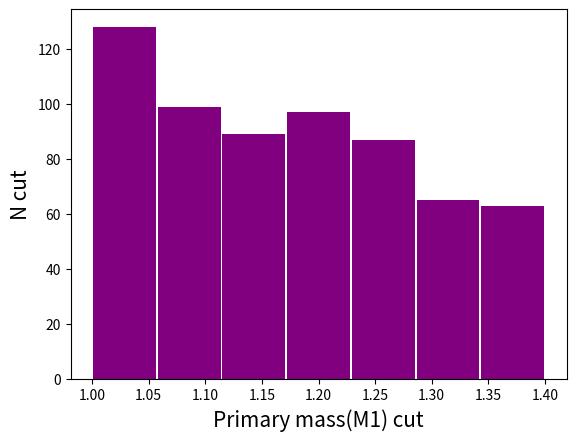

In [ ]:
counts6, bins6, bars6 = plt.hist(cutSingleGaiaData['m1Mean'],bins=np.linspace(1,1.4, 8),linewidth=2,color='purple',rwidth=0.97)
plt.ylabel('N cut',fontsize=15)
plt.xlabel('Primary mass(M1) cut',fontsize=15)

In [ ]:
bins6

array([1.        , 1.05714286, 1.11428571, 1.17142857, 1.22857143,
       1.28571429, 1.34285714, 1.4       ])

Text(0.5, 0, 'primary mass cut')

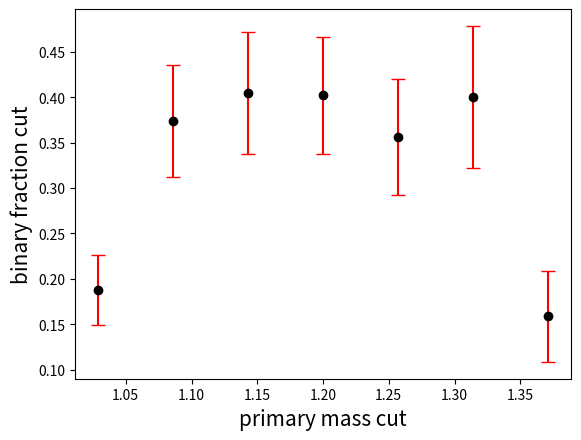

In [ ]:
# the arrays arent the same size. should i be getting rid of the first bin value or last?
primarybins2 = bins5[:-1] + (bins5[1]-bins5[0])/2
errors_y4 = np.sqrt(counts5)/counts6
plt.errorbar(primarybins2, counts5/counts6, xerr=None, yerr=errors_y4, fmt='o',capsize=5, color='black', ecolor='red')
plt.ylabel('binary fraction cut',fontsize=15)
plt.xlabel('primary mass cut',fontsize=15)

Text(0, 0.5, 'primary mass cut')

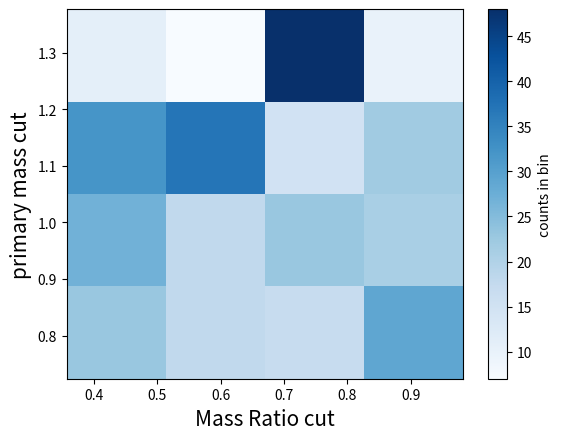

In [ ]:
plt.hist2d(cutBinaryGaiaData['qMean'], cutBinaryGaiaData['m1Mean'], bins=4, cmap='Blues')
cb = plt.colorbar(label='counts in bin')
plt.xlabel('Mass Ratio cut',fontsize=15)
plt.ylabel('primary mass cut',fontsize=15)

Text(0, 0.5, 'distance cut')

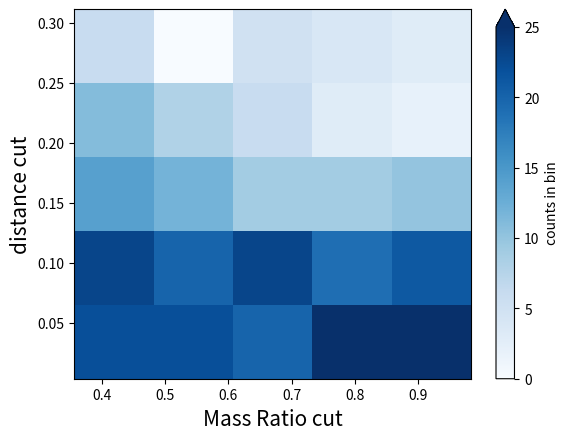

In [ ]:
#qmean and distance
plt.hist2d(cutBinaryGaiaData['qMean'], cutBinaryGaiaData['distance'], bins=5, cmap='Blues', vmax=25)
cb2 = plt.colorbar(extend="max",label='counts in bin')
plt.xlabel('Mass Ratio cut',fontsize=15)
plt.ylabel('distance cut',fontsize=15)

Text(0, 0.5, 'N (binaries) cut')

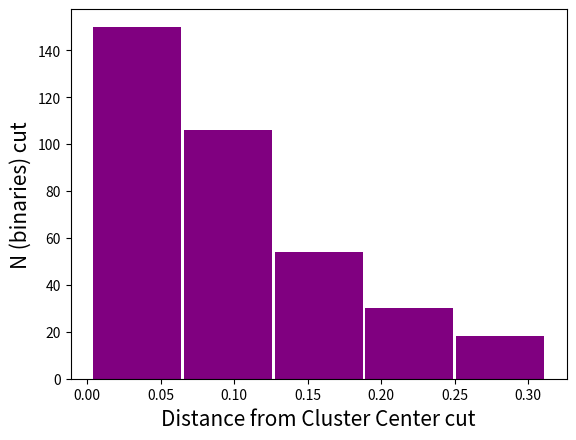

In [ ]:
counts7, bins7, bars7 =plt.hist(cutBinaryGaiaData['distance'], bins=5,linewidth=2,color='purple',rwidth=0.97)
plt.xlabel('Distance from Cluster Center cut',fontsize=15)
plt.ylabel('N (binaries) cut',fontsize=15)

Text(0, 0.5, 'N cut')

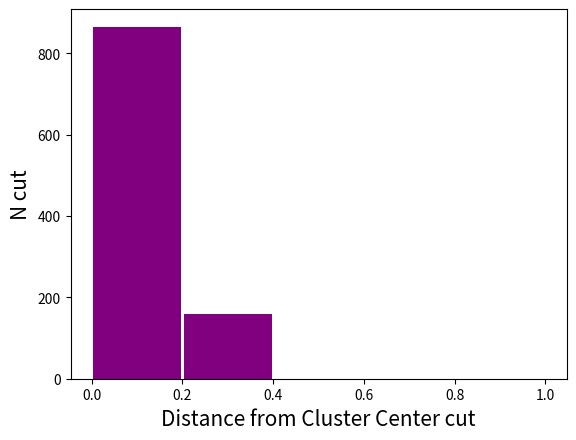

In [ ]:
counts8, bins8, bars8 = plt.hist(cutSingleGaiaData['distance'], bins=5, range=[0,1],linewidth=2,color='purple',rwidth=0.97)
plt.xlabel('Distance from Cluster Center cut',fontsize=15)
plt.ylabel('N cut',fontsize=15)

In [ ]:

bins7 = [0.2,0.4,0.6,0.8,1]
bins8 = [0,0.2,0.4,0.6,0.8,1]
bins7 

[0.2, 0.4, 0.6, 0.8, 1]

In [ ]:
# is this the right way to do error? can we factor in the std of the values themselves?
errors_y2 = np.sqrt(counts7)/counts8


/var/folders/_w/2tvx5cms23s29hpbx7ncw_cr0000gn/T/ipykernel_5821/2702057577.py:2: RuntimeWarning: divide by zero encountered in divide
  errors_y2 = np.sqrt(counts7)/counts8


6 5


/var/folders/_w/2tvx5cms23s29hpbx7ncw_cr0000gn/T/ipykernel_5821/1527049848.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.errorbar(bins8, counts7/counts8, xerr=None, yerr=errors_y2, fmt='o',capsize=5, color='black', ecolor='red')


ValueError: 'x' and 'y' must have the same size

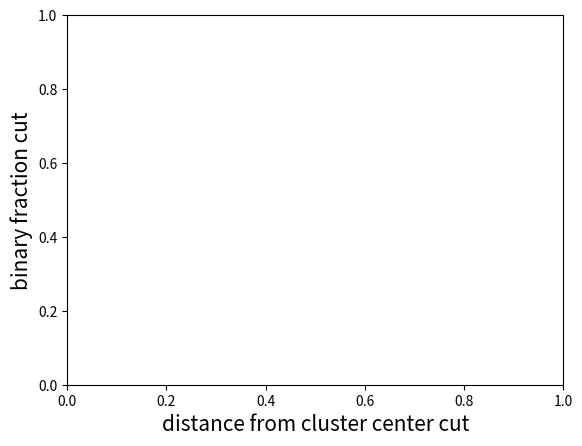

In [ ]:
plt.xlabel('distance from cluster center cut',fontsize=15)
plt.ylabel('binary fraction cut',fontsize=15)
print(len(bins8), len(errors_y2))
plt.errorbar(bins8, counts7/counts8, xerr=None, yerr=errors_y2, fmt='o',capsize=5, color='black', ecolor='red')


In [ ]:
cutBinaryGaiaData.columns

Index(['G', 'G_BP', 'G_RP_x', 'ra', 'dec', 'G_RP_y', 'qMean', 'qStd', 'm1Mean',
       'm2Mean', 'distance'],
      dtype='object')

(23.0, 12.0)

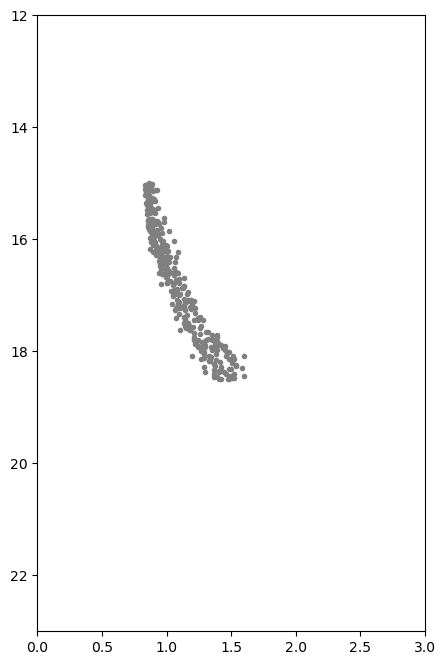

In [ ]:
f, ax = plt.subplots(figsize=(5,8))
ax.plot(cutBinaryGaiaData['G_BP'] - cutBinaryGaiaData['G_RP_x'], cutBinaryGaiaData['G'],'.', color='gray')
ax.set_xlim(0, 3)
ax.set_ylim(23, 12)

(23.0, 12.0)

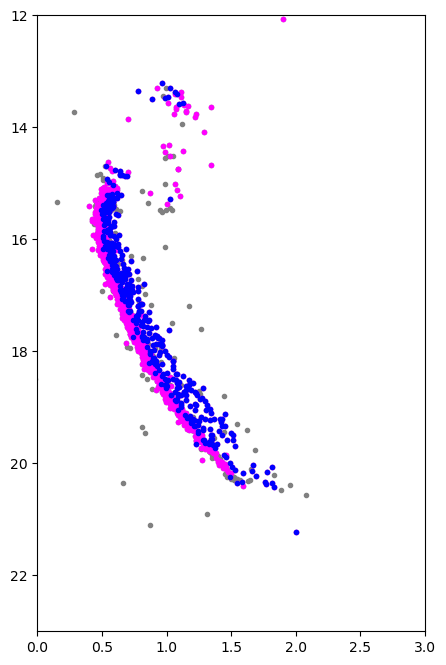

In [ ]:
f, ax = plt.subplots(figsize=(5,8))
photMems = phot.loc[phot['member']]
photBinary = phot.loc[phot['binary']]
ax.plot(phot['g_ps'] - phot['i_ps'], phot['g_ps'],'.', color='gray')
ax.plot(photMems['g_ps'] - photMems['i_ps'], photMems['g_ps'],'.', color='magenta')
ax.plot(photBinary['g_ps'] - photBinary['i_ps'], photBinary['g_ps'],'.', color='blue')
ax.set_xlim(0, 3)
ax.set_ylim(23, 12)

In [ ]:
photBinary

,id,G,G_BP,G_RP,g_ps,r_ps,i_ps,z_ps,y_ps,J_2M,...,m1Mean,m1Std,m2Mean,m2Std,qMean,qStd,memMean,memStd,member,binary
18,10079200118,12.5085,13.0806,11.7925,99.9000,99.9000,99.9000,99.9000,99.9000,10.843,...,1.587656,-1,1.543199,-1,0.972027,0.052500,0.995932,6.365169e-02,True,True
19,10014000119,12.5173,13.1115,11.7863,13.3066,12.6870,12.2810,12.0270,11.9090,10.790,...,1.595815,-1,1.452335,-1,0.910220,0.182120,0.944925,2.280457e-01,True,True
20,10291800122,12.5621,13.1809,11.8130,13.3745,12.7150,12.3100,12.0640,11.9320,10.804,...,1.598595,-1,1.277282,-1,0.799065,0.166017,0.999998,3.616864e-05,True,True
21,10320700125,12.5894,13.1961,11.8481,13.3969,12.7100,12.3140,12.0760,11.9540,10.844,...,1.594874,-1,1.401906,-1,0.879090,0.047201,0.998533,3.405517e-02,True,True
22,10276600132,12.6390,13.2478,11.8866,13.3457,13.0830,12.5690,12.2340,12.0017,10.867,...,1.597176,-1,1.316464,-1,0.824260,0.047268,0.999882,2.579837e-03,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1877,10588715865,19.2640,19.9550,18.4009,20.2450,19.1709,18.7523,99.9000,18.1414,99.900,...,0.705049,-1,0.343375,-1,0.487273,0.092093,1.000000,0.000000e+00,True,True
1879,11196416068,19.2877,99.9000,99.9000,99.9000,99.9000,99.9000,99.9000,99.9000,16.319,...,0.641565,-1,0.624274,-1,0.973296,0.023495,0.998745,1.297811e-02,True,True
1880,10006017074,19.4167,99.9000,99.9000,99.9000,99.9000,18.6213,99.9000,99.9000,99.900,...,0.635973,-1,0.619667,-1,0.974574,0.021689,1.000000,0.000000e+00,True,True
1883,11717518632,19.6066,99.9000,99.9000,99.9000,19.6921,18.1839,18.7557,18.6017,99.900,...,0.655270,-1,0.448548,-1,0.686959,0.124208,1.000000,5.665158e-08,True,True


In [ ]:
photBinary

,id,G,G_BP,G_RP,g_ps,r_ps,i_ps,z_ps,y_ps,J_2M,...,m1Mean,m1Std,m2Mean,m2Std,qMean,qStd,memMean,memStd,member,binary
18,10079200118,12.5085,13.0806,11.7925,99.9000,99.9000,99.9000,99.9000,99.9000,10.843,...,1.587656,-1,1.543199,-1,0.972027,0.052500,0.995932,6.365169e-02,True,True
19,10014000119,12.5173,13.1115,11.7863,13.3066,12.6870,12.2810,12.0270,11.9090,10.790,...,1.595815,-1,1.452335,-1,0.910220,0.182120,0.944925,2.280457e-01,True,True
20,10291800122,12.5621,13.1809,11.8130,13.3745,12.7150,12.3100,12.0640,11.9320,10.804,...,1.598595,-1,1.277282,-1,0.799065,0.166017,0.999998,3.616864e-05,True,True
21,10320700125,12.5894,13.1961,11.8481,13.3969,12.7100,12.3140,12.0760,11.9540,10.844,...,1.594874,-1,1.401906,-1,0.879090,0.047201,0.998533,3.405517e-02,True,True
22,10276600132,12.6390,13.2478,11.8866,13.3457,13.0830,12.5690,12.2340,12.0017,10.867,...,1.597176,-1,1.316464,-1,0.824260,0.047268,0.999882,2.579837e-03,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1877,10588715865,19.2640,19.9550,18.4009,20.2450,19.1709,18.7523,99.9000,18.1414,99.900,...,0.705049,-1,0.343375,-1,0.487273,0.092093,1.000000,0.000000e+00,True,True
1879,11196416068,19.2877,99.9000,99.9000,99.9000,99.9000,99.9000,99.9000,99.9000,16.319,...,0.641565,-1,0.624274,-1,0.973296,0.023495,0.998745,1.297811e-02,True,True
1880,10006017074,19.4167,99.9000,99.9000,99.9000,99.9000,18.6213,99.9000,99.9000,99.900,...,0.635973,-1,0.619667,-1,0.974574,0.021689,1.000000,0.000000e+00,True,True
1883,11717518632,19.6066,99.9000,99.9000,99.9000,19.6921,18.1839,18.7557,18.6017,99.900,...,0.655270,-1,0.448548,-1,0.686959,0.124208,1.000000,5.665158e-08,True,True


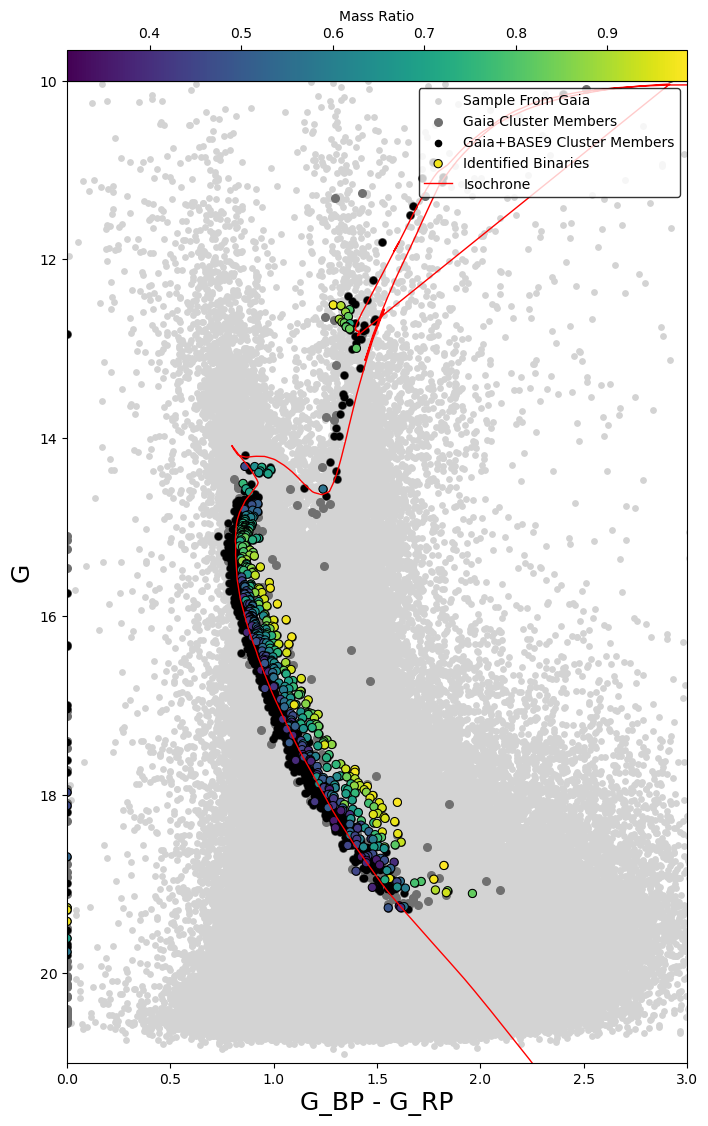

In [ ]:
r = photBinary['qMean']
f, ax = plt.subplots(figsize=(8,15))

ax.set_xlabel('G_BP - G_RP',fontsize=18)
ax.set_ylabel('G',fontsize=18)
#plot phot and cluster members
plt.scatter(originalGaia['phot_bp_mean_mag'] - originalGaia['phot_rp_mean_mag'], originalGaia['phot_g_mean_mag'],s=15, color='lightgray',label='Sample From Gaia')
plt.scatter(phot['G_BP'] - phot['G_RP'], phot['G'],s=30, color='#707070',label='Gaia Cluster Members')
plt.scatter(photMems['G_BP'] - photMems['G_RP'], photMems['G'],s=20, color='#000000',label='Gaia+BASE9 Cluster Members')
#plt.scatter(photBinary['g_ps'] - photBinary['i_ps'], photBinary['g_ps'], color='#000000')
ax.set_xlim(0, 3)
ax.set_ylim(21,10)


#plot colorbar
plt.scatter(photBinary['G_BP'] - photBinary['G_RP'], photBinary['G'], s=35, c=r, cmap=plt.cm.get_cmap("viridis"),edgecolors= "black",linewidth=0.75,label='Identified Binaries')

plt.colorbar(label="Mass Ratio", orientation="horizontal",pad=0,location='top')


#overplot isochrone
photfile = ph
cmdfile = r"/Users/Claire/Documents/Code/current/ANNACRNN/plotting/run21_int_19co_ov/NGC6819.ms"
mag       = 'G'
color     = 'G_BP-G_RP'.split('-')
header   = np.loadtxt(cmdfile,max_rows=1,dtype=str)
yplot     = np.where(header == mag)[0][0]
color1    = np.where(header == color[0])[0][0]
color2    = np.where(header == color[1])[0][0]
data = np.loadtxt(cmdfile,skiprows=1)
ymag    = data[:,yplot]
color   = data[:,color1] - data[:,color2]
plt.plot(color, ymag, color='red',linewidth=1,label='Isochrone')
plt.legend(loc="upper right",edgecolor='black')
#plt.show()
plt.savefig('MegaCMD1.png',dpi=300, bbox_inches="tight")
    


Text(0, 0.5, 'N')

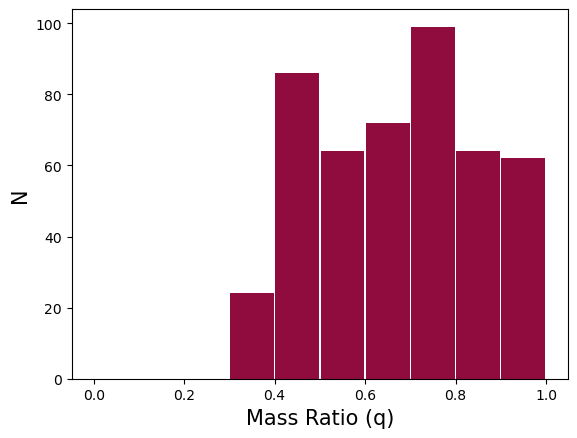

In [ ]:
f, ax = plt.subplots()
photBinary = phot.loc[phot['binary']]
_ = ax.hist(photBinary['qMean'], bins=10, range=[0,1],linewidth=2,color='#900C3F',rwidth=0.97)
ax.set_xlabel('Mass Ratio (q)',fontsize=15)
ax.set_ylabel('N',fontsize=15)
#plt.savefig('M67qhist1.png',dpi=300, bbox_inches="tight")

(21.0, 10.0)

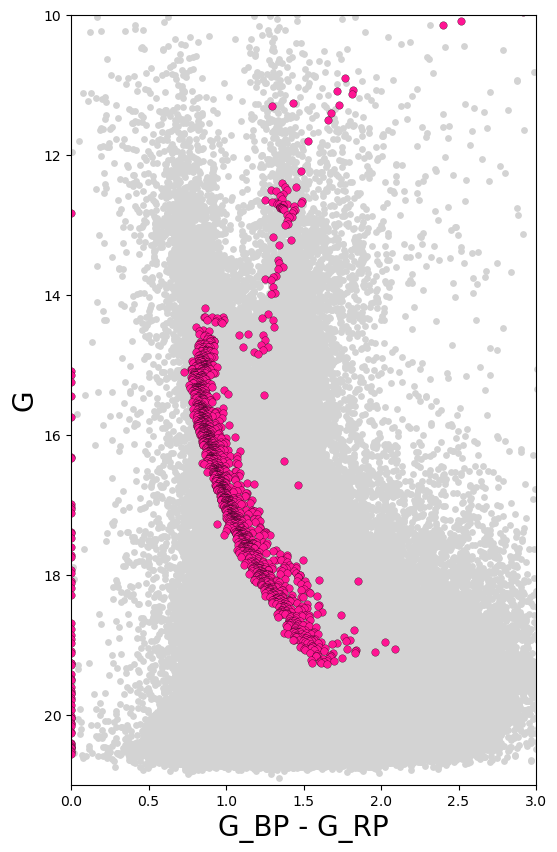

In [ ]:
f, ax = plt.subplots(figsize=(6,10))

ax.set_xlabel('G_BP - G_RP',fontsize=20)
ax.set_ylabel('G',fontsize=20)
#plot phot and cluster members
plt.scatter(M67.data['phot_bp_mean_mag'] - M67.data['phot_rp_mean_mag'], M67.data['phot_g_mean_mag'],s=15, color='lightgray',label='Sample From Gaia')
plt.scatter(phot['G_BP'] - phot['G_RP'], phot['G'],s=30, color='Deeppink',label='Gaia Cluster Members', edgecolors= "black",linewidth=0.2)
ax.set_xlim(0, 3)
ax.set_ylim(21,10)
#plt.savefig('M67cmd.png', bbox='tight',dpi=300)